In [255]:
!pip3 install tensorflow
!pip3 install kagglehub


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [256]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from tensorflow import keras
from keras import layers
import time
import gc

In [ ]:
file_path = os.path.join("wre.us.txt")
df = pd.read_csv(file_path)
header = df.columns.tolist()
price = df["Close"].to_numpy()             
raw_data = df.iloc[:, 1:].to_numpy() 


# Punto 1



In [258]:

price_high = df["High"].to_numpy()
price_low = df["Low"].to_numpy()
price = (price_high + price_low) / 2
price = price.reshape(-1, 1)  

## Grafica del valor promedio de la acción seleccionada

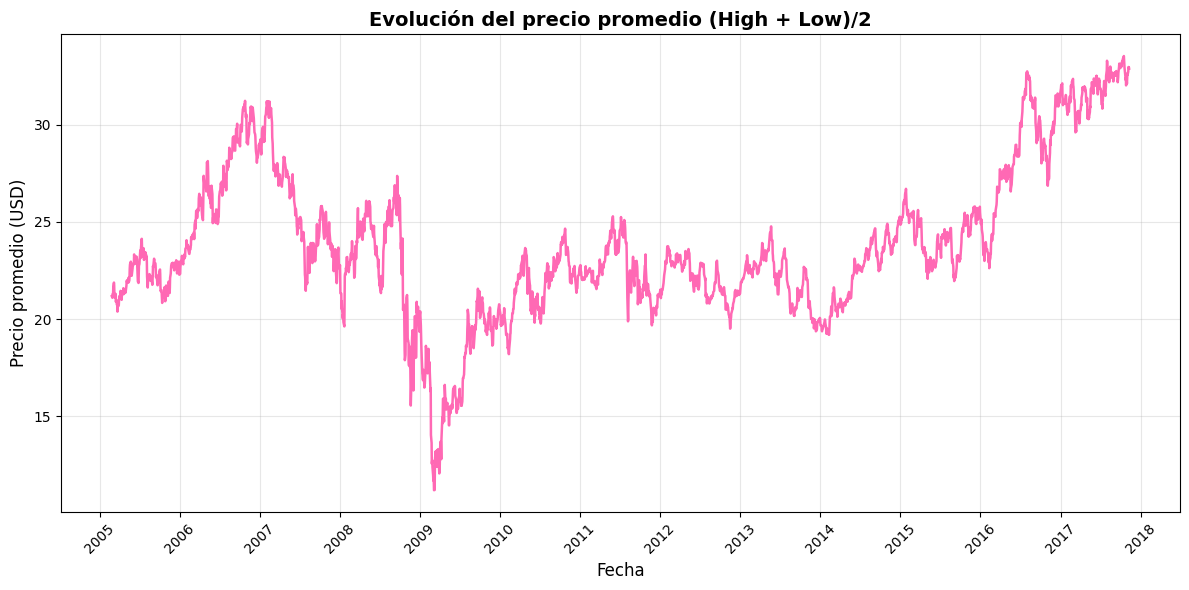

In [ ]:


df["Date"] = pd.to_datetime(df["Date"])

plt.figure(figsize=(12,6))
plt.plot(df["Date"], price, color='hotpink', linewidth=1.8)


plt.title("Evolución del precio promedio (High + Low)/2", fontsize=14, weight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio promedio (USD)", fontsize=12)


plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))       
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 


plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Normalization

In [260]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1600
num_val_samples: 800
num_test_samples: 801


In [ ]:

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)

# Identificar columnas constantes
constant_cols = np.where(std == 0)[0]
column_names = df.columns[1:]


std[std == 0] = 1 
raw_data /= std

mean_price = price[:num_train_samples].mean()
std_price = price[:num_train_samples].std()

price_norm = (price - mean_price) / std_price
price = price_norm



Columnas constantes: Index(['OpenInt'], dtype='object')
Número de columnas constantes: 1


### Clase para crear los modelos a entrenar

In [ ]:


class ModelBuilder:
    def __init__(self, raw_data, price, sequence_length):
        self.raw_data = raw_data
        self.price = price
        self.sequence_length = sequence_length
        self.models = {}
        self.histories = {}
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

 
    def create_datasets(self, delay, batch_size, sampling_rate, num_train_samples, num_val_samples):
        self.train_dataset = keras.utils.timeseries_dataset_from_array(
            data=self.raw_data[:-delay],
            targets=self.price[delay:],
            sequence_length=self.sequence_length,
            sampling_rate=sampling_rate,
            shuffle=False,
            batch_size=batch_size,
            start_index=0,
            end_index=num_train_samples
        )

        self.val_dataset = keras.utils.timeseries_dataset_from_array(
            data=self.raw_data[:-delay],
            targets=self.price[delay:],
            sequence_length=self.sequence_length,
            sampling_rate=sampling_rate,
            shuffle=False,
            batch_size=batch_size,
            start_index=num_train_samples,
            end_index=num_train_samples + num_val_samples
        )

        self.test_dataset = keras.utils.timeseries_dataset_from_array(
            data=self.raw_data[:-delay],
            targets=self.price[delay:],
            sequence_length=self.sequence_length,
            sampling_rate=sampling_rate,
            shuffle=False,
            batch_size=batch_size,
            start_index=num_train_samples + num_val_samples
        )

        return self.train_dataset, self.val_dataset, self.test_dataset

   
    def create_LSTM_model(self, num_neurons, epochs, dropout_rate=0.0, use_recurrent_dropout=False, name_model="LSTM"):
        inputs = keras.Input(shape=(self.sequence_length, self.raw_data.shape[-1]))
        x = layers.LSTM(num_neurons, recurrent_dropout=dropout_rate if use_recurrent_dropout else 0)(inputs)
        outputs = layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)
        
        callbacks = [keras.callbacks.ModelCheckpoint(f"{name_model}.keras", save_best_only=True)] 
        
        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"]) 
        history = model.fit(self.train_dataset, epochs=epochs, validation_data=self.val_dataset, callbacks=callbacks) 
        model = keras.models.load_model(f"{name_model}.keras") 
        print(f"Test MAE: {model.evaluate(self.test_dataset)[1]:.2f}")


        self.models[name_model] = model
        self.histories[name_model] = history
        return model, history

 
    def create_GRU_model(self, num_neurons, epochs, dropout_rate=0.0, use_recurrent_dropout=False, name_model="GRU"):
        inputs = keras.Input(shape=(self.sequence_length, self.raw_data.shape[-1]))
        x = layers.GRU(num_neurons, recurrent_dropout=dropout_rate if use_recurrent_dropout else 0)(inputs)
        outputs = layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)

        callbacks = [keras.callbacks.ModelCheckpoint(f"{name_model}.keras", save_best_only=True)] 
        
        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"]) 
        history = model.fit(self.train_dataset, epochs=epochs, validation_data=self.val_dataset, callbacks=callbacks)
        model = keras.models.load_model(f"{name_model}.keras")

        print(f"Test MAE: {model.evaluate(self.test_dataset)[1]:.2f}")
        self.models[name_model] = model
        self.histories[name_model] = history
        return model, history

  
    def create_stacked_GRU(self, num_l1, num_l2, epochs, name_model="Stacked_GRU"):
        num_features = self.raw_data.shape[-1]
        output_dim = 1

        model = tf.keras.Sequential([
            tf.keras.layers.GRU(num_l1, return_sequences=True, input_shape=(self.sequence_length, num_features)),
            tf.keras.layers.GRU(num_l2, return_sequences=False),
            tf.keras.layers.Dense(output_dim, activation='linear')
        ])

        callbacks = [keras.callbacks.ModelCheckpoint(f"{name_model}.keras", save_best_only=True)] 
        
        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"]) 
        history = model.fit(self.train_dataset, epochs=epochs, validation_data=self.val_dataset, callbacks=callbacks) 
        model = keras.models.load_model(f"{name_model}.keras")

        print(f"Test MAE: {model.evaluate(self.test_dataset)[1]:.2f}")
        self.models[name_model] = model
        self.histories[name_model] = history
        return model, history
    
    
    def graph_history(self,history):
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(1, len(loss) + 1)
        plt.figure()
        plt.plot(epochs, loss, "lightpink", label="Training Loss")
        plt.plot(epochs, val_loss, "purple", label="Validation Loss")
        plt.title("Training and validation Loss (MSE)")
        plt.legend()
        plt.show()
        
        
    
    def graph_prediction(self,y_true, predictions):
        plt.figure(figsize=(10, 5))
        plt.plot(y_true[20:40], label='True Values', color='pink')
        plt.plot(predictions[20:40], label='Predicted Values', color='purple')
        plt.title('Predictions vs True Values')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    
    
    def predict(self, model):
        if model is None:
            raise ValueError(f"Modelo {model} no existe.")
        
        
        y_true = np.concatenate([y for x, y in self.test_dataset], axis=0)
        predictions = model.predict(self.test_dataset)
        
       
        y_true = y_true.flatten()  
        predictions = predictions.flatten()  
        
        
        if len(y_true) != len(predictions):
            min_len = min(len(y_true), len(predictions))
            y_true = y_true[:min_len]
            predictions = predictions[:min_len]
            print(f" Ajustadas longitudes: {min_len} muestras")
        
        return y_true, predictions

   
    def calculate_metrics(self, y_true, predictions):
        
        
        mae = np.mean(np.abs(y_true - predictions))
        mse = np.mean((y_true - predictions)**2)
        rmse = np.sqrt(mse)
        
        print(f"MAE: {mae:.4f}")
        print(f"MSE: {mse:.4f}") 
        print(f"RMSE: {rmse:.4f}")
        
        return mae, mse, rmse
    
    



# Pruebas

In [ ]:
builder = ModelBuilder(raw_data, price, sequence_length=30)

# Crear datasets
builder.create_datasets(delay=1, batch_size=32, sampling_rate=1,
                        num_train_samples=num_train_samples,
                        num_val_samples=num_val_samples)



X idx aproximado: tf.Tensor([ 0.44260044  0.37748938  0.36888542  0.29242287 -0.34023286  0.        ], shape=(6,), dtype=float64)
y[0]: [0.29478618]


In [265]:
builder2 = ModelBuilder(raw_data, price, sequence_length=60)

# Crear datasets
builder2.create_datasets(delay=1, batch_size=64, sampling_rate=1,
                        num_train_samples=num_train_samples,
                        num_val_samples=num_val_samples)


(<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [ ]:
builder3 = ModelBuilder(raw_data, price, sequence_length=90)

# Crear datasets
builder3.create_datasets(delay=1, batch_size=128, sampling_rate=1,
                        num_train_samples=num_train_samples,
                        num_val_samples=num_val_samples)


(<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

# Punto 2

In [267]:
model_lstm1_1, hist_lstm1_1 = builder.create_LSTM_model(num_neurons=64, epochs=100,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM1_1_64")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.2285 - mae: 0.3637 - val_loss: 0.0809 - val_mae: 0.2246
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1970 - mae: 0.3328 - val_loss: 0.0744 - val_mae: 0.2100
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2033 - mae: 0.3279 - val_loss: 0.0693 - val_mae: 0.2039
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1914 - mae: 0.3195 - val_loss: 0.0641 - val_mae: 0.1988
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1934 - mae: 0.3173 - val_loss: 0.0609 - val_mae: 0.1973
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1762 - mae: 0.3068 - val_loss: 0.0577 - val_mae: 0.1953
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1841 - mae: 0.3052 - val_loss: 0.0572 - val_mae: 0.1946
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1695 - mae: 0.2968 - val_loss: 0.0515 - val_mae: 0.1839
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

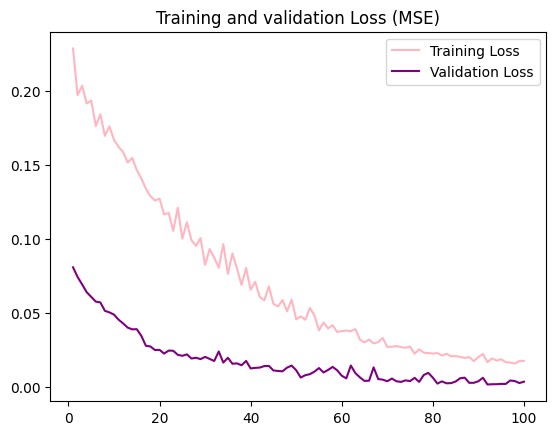

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
MAE: 0.1869
MSE: 0.0951
RMSE: 0.3084


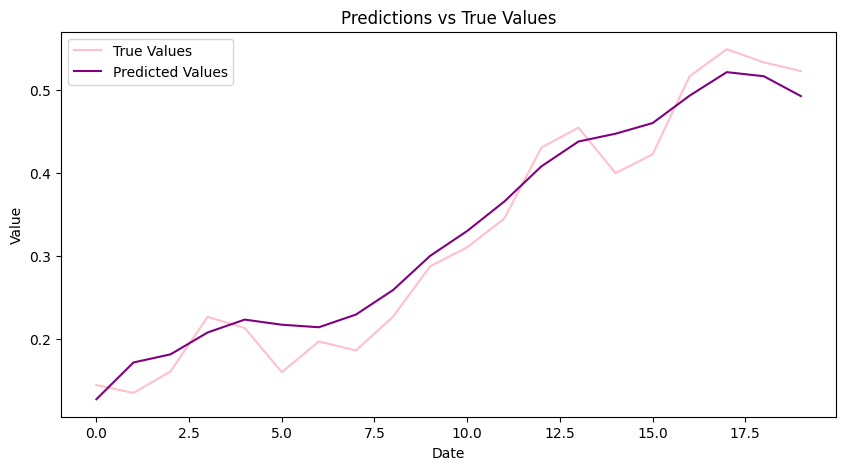

In [268]:
builder.graph_history(hist_lstm1_1)
y_true, predictions = builder.predict(model_lstm1_1)
builder.calculate_metrics(y_true, predictions)
builder.graph_prediction(y_true, predictions)


In [269]:
model_lstm1_2, hist_lstm1_2 = builder.create_LSTM_model(num_neurons=128, epochs=100,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM1_2_128")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.2550 - mae: 0.3726 - val_loss: 0.0790 - val_mae: 0.2191
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2153 - mae: 0.3422 - val_loss: 0.0718 - val_mae: 0.2050
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2019 - mae: 0.3275 - val_loss: 0.0657 - val_mae: 0.1965
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1983 - mae: 0.3163 - val_loss: 0.0612 - val_mae: 0.1943
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1913 - mae: 0.3095 - val_loss: 0.0584 - val_mae: 0.1919
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1724 - mae: 0.2958 - val_loss: 0.0572 - val_mae: 0.1916
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1794 - mae: 0.2974 - val_loss: 0.0552 - val_mae: 0.1893
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1668 - mae: 0.2910 - val_loss: 0.0520 - val_mae: 0.1833
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - lo

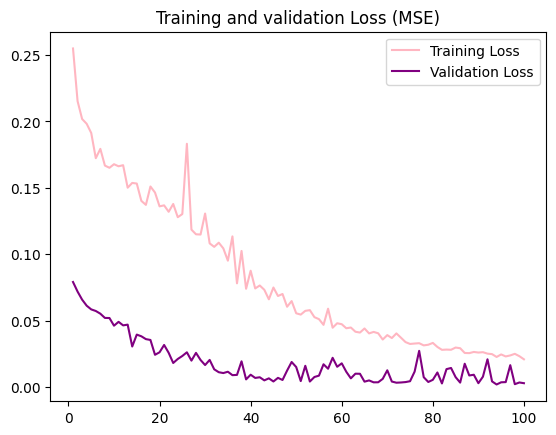

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
MAE: 0.2109
MSE: 0.1132
RMSE: 0.3365


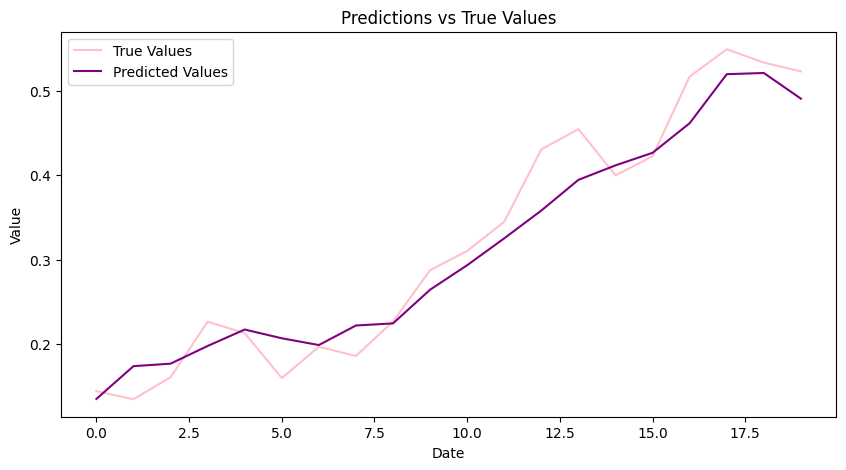

In [ ]:
builder.graph_history(hist_lstm1_2)
y_true, predictions = builder.predict(model_lstm1_2)
builder.calculate_metrics(y_true, predictions)
builder.graph_prediction(y_true, predictions)

In [271]:
model_lstm1_3, hist_lstm1_3 = builder.create_LSTM_model(num_neurons=32, epochs=100,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM1_3_32")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2956 - mae: 0.4195 - val_loss: 0.1041 - val_mae: 0.2541
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2341 - mae: 0.3726 - val_loss: 0.1009 - val_mae: 0.2443
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2195 - mae: 0.3572 - val_loss: 0.0971 - val_mae: 0.2384
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2098 - mae: 0.3463 - val_loss: 0.0924 - val_mae: 0.2328
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2030 - mae: 0.3394 - val_loss: 0.0890 - val_mae: 0.2280
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1913 - mae: 0.3286 - val_loss: 0.0857 - val_mae: 0.2236
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1880 - mae: 0.3248 - val_loss: 0.0797 - val_mae: 0.2169
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1769 - mae: 0.3157 - val_loss: 0.0760 - val_mae: 0.2113
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - lo

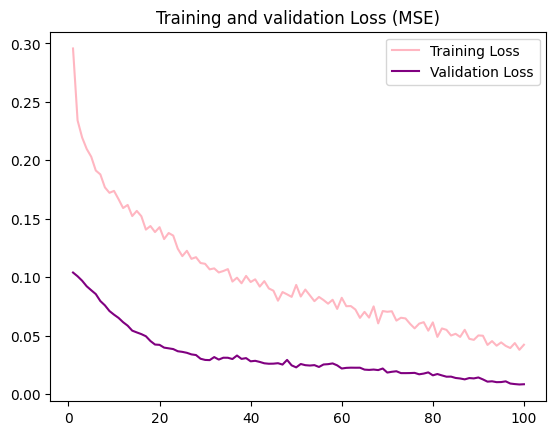

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
MAE: 0.1937
MSE: 0.0684
RMSE: 0.2616


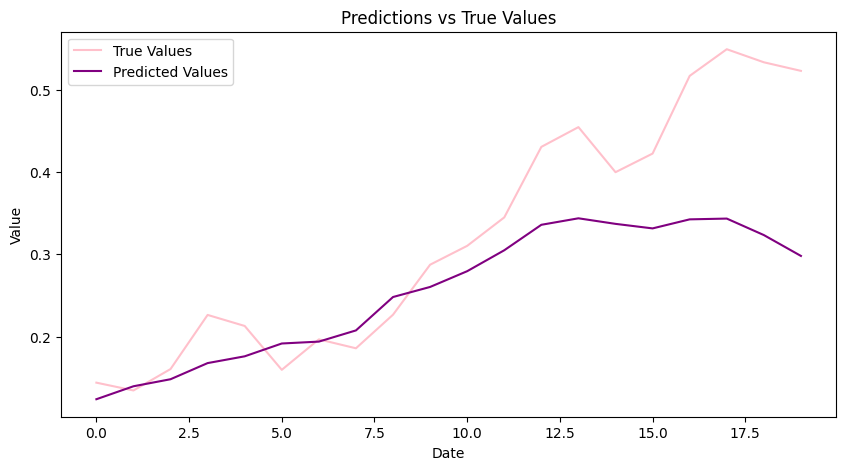

In [ ]:
builder.graph_history(hist_lstm1_3)
y_true, predictions = builder.predict(model_lstm1_3)
builder.calculate_metrics(y_true, predictions)
builder.graph_prediction(y_true, predictions)

In [273]:
model_lstm1_4, hist_lstm1_4 = builder.create_LSTM_model(num_neurons=32, epochs=100,
                                                  dropout_rate=0.2, use_recurrent_dropout=False,
                                                  name_model="LSTM1_4_32")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.2613 - mae: 0.3860 - val_loss: 0.1019 - val_mae: 0.2490
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2287 - mae: 0.3582 - val_loss: 0.0956 - val_mae: 0.2383
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2123 - mae: 0.3431 - val_loss: 0.0896 - val_mae: 0.2306
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1990 - mae: 0.3323 - val_loss: 0.0835 - val_mae: 0.2240
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1855 - mae: 0.3214 - val_loss: 0.0768 - val_mae: 0.2165
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1725 - mae: 0.3103 - val_loss: 0.0699 - val_mae: 0.2088
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1634 - mae: 0.3012 - val_loss: 0.0632 - val_mae: 0.2009
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1544 - mae: 0.2915 - val_loss: 0.0574 - val_mae: 0.1933
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - l

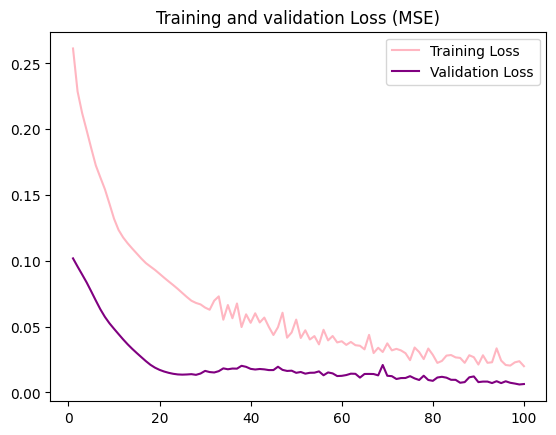

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
MAE: 0.2371
MSE: 0.1147
RMSE: 0.3387


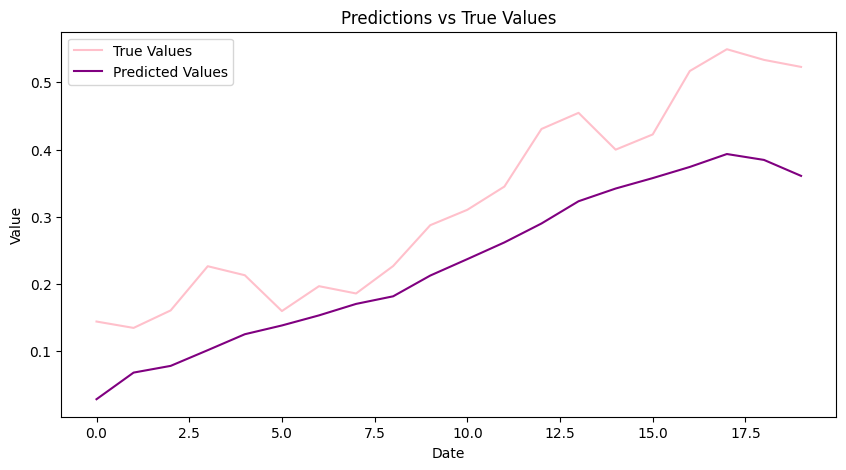

In [ ]:
builder.graph_history(hist_lstm1_4)
y_true, predictions = builder.predict(model_lstm1_4)
builder.calculate_metrics(y_true, predictions)
builder.graph_prediction(y_true, predictions)

In [275]:
model_lstm2_1, hist_lstm2_1 = builder2.create_LSTM_model(num_neurons=64, epochs=125,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM2_1_64")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.6460 - mae: 0.6096 - val_loss: 0.1285 - val_mae: 0.2999
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.4728 - mae: 0.5483 - val_loss: 0.1362 - val_mae: 0.3093
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.4316 - mae: 0.5263 - val_loss: 0.1325 - val_mae: 0.3041
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.4250 - mae: 0.5212 - val_loss: 0.1303 - val_mae: 0.3013
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.4091 - mae: 0.5083 - val_loss: 0.1254 - val_mae: 0.2952
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.3781 - mae: 0.4917 - val_loss: 0.1184 - val_mae: 0.2862
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.3479 - mae: 0.4774 - val_loss: 0.1099 - val_mae: 0.2758
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.3286 - mae: 0.4618 - val_loss: 0.1069 - val_mae: 0.2717
Epoch 9/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - lo

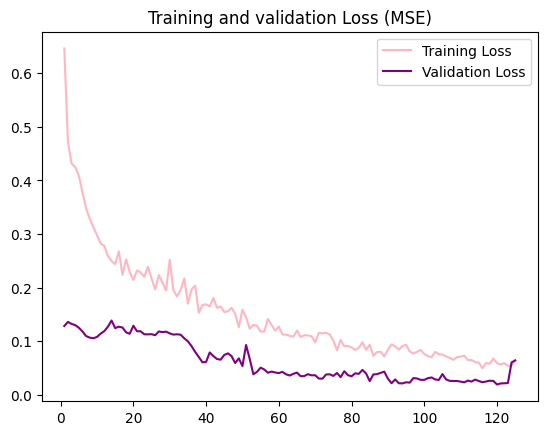

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
MAE: 0.2822
MSE: 0.1357
RMSE: 0.3684


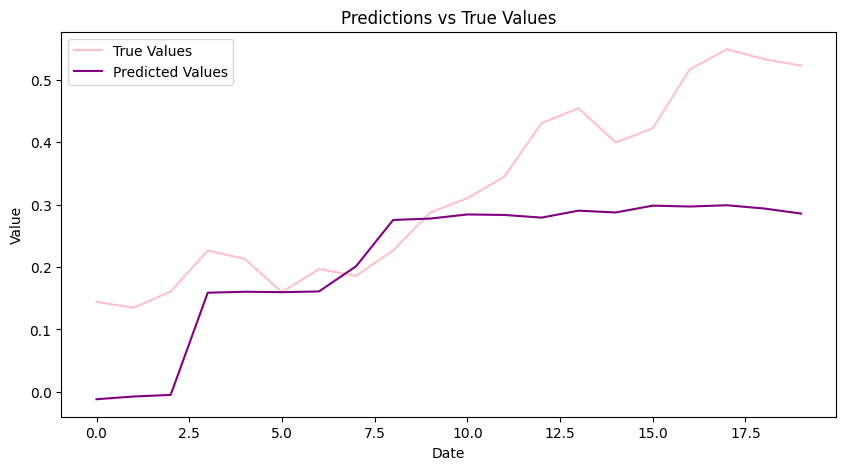

In [ ]:
builder2.graph_history(hist_lstm2_1)
y_true, predictions = builder2.predict(model_lstm2_1)
builder2.calculate_metrics(y_true, predictions)
builder2.graph_prediction(y_true, predictions)

In [277]:
model_lstm2_2, hist_lstm2_2 = builder2.create_LSTM_model(num_neurons=128, epochs=125,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM2_2_128")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.5419 - mae: 0.5915 - val_loss: 0.1466 - val_mae: 0.3204
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.4404 - mae: 0.5409 - val_loss: 0.1451 - val_mae: 0.3197
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.4349 - mae: 0.5361 - val_loss: 0.1428 - val_mae: 0.3173
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.4190 - mae: 0.5276 - val_loss: 0.1376 - val_mae: 0.3113
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.3712 - mae: 0.4947 - val_loss: 0.1332 - val_mae: 0.3058
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.3611 - mae: 0.4912 - val_loss: 0.1269 - val_mae: 0.2977
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.3645 - mae: 0.4903 - val_loss: 0.1210 - val_mae: 0.2881
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.3327 - mae: 0.4611 - val_loss: 0.1157 - val_mae: 0.2806
Epoch 9/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - lo

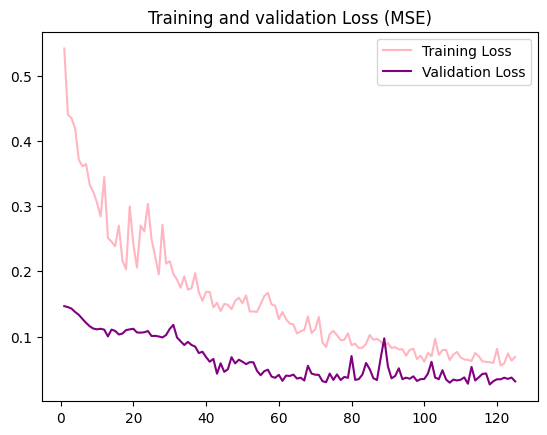

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
MAE: 0.2714
MSE: 0.1134
RMSE: 0.3368


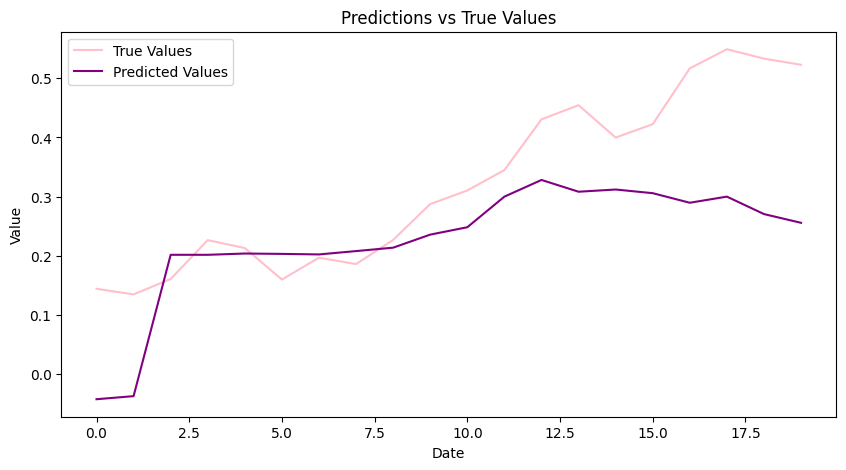

In [ ]:
builder2.graph_history(hist_lstm2_2)
y_true, predictions = builder2.predict(model_lstm2_2)
builder2.calculate_metrics(y_true, predictions)
builder2.graph_prediction(y_true, predictions)

In [279]:
model_lstm2_3, hist_lstm2_3 = builder2.create_LSTM_model(num_neurons=32, epochs=125,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM2_3_32")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.0399 - mae: 0.7559 - val_loss: 0.1237 - val_mae: 0.2904
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6101 - mae: 0.6004 - val_loss: 0.1267 - val_mae: 0.2986
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.4966 - mae: 0.5605 - val_loss: 0.1419 - val_mae: 0.3165
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.4624 - mae: 0.5450 - val_loss: 0.1494 - val_mae: 0.3239
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.4410 - mae: 0.5345 - val_loss: 0.1529 - val_mae: 0.3271
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.4360 - mae: 0.5308 - val_loss: 0.1525 - val_mae: 0.3264
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.4255 - mae: 0.5255 - val_loss: 0.1512 - val_mae: 0.3249
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4171 - mae: 0.5199 - val_loss: 0.1487 - val_mae: 0.3221
Epoch 9/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - lo

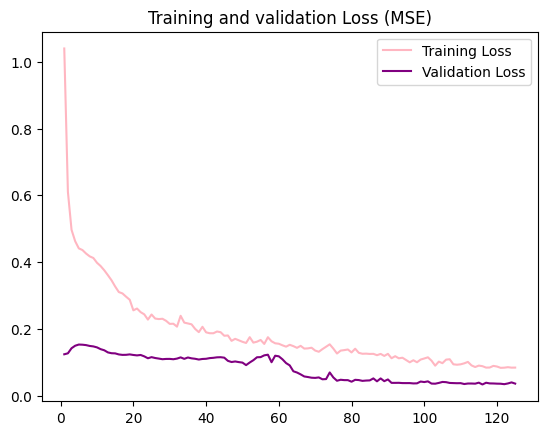

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
MAE: 0.3154
MSE: 0.1613
RMSE: 0.4016


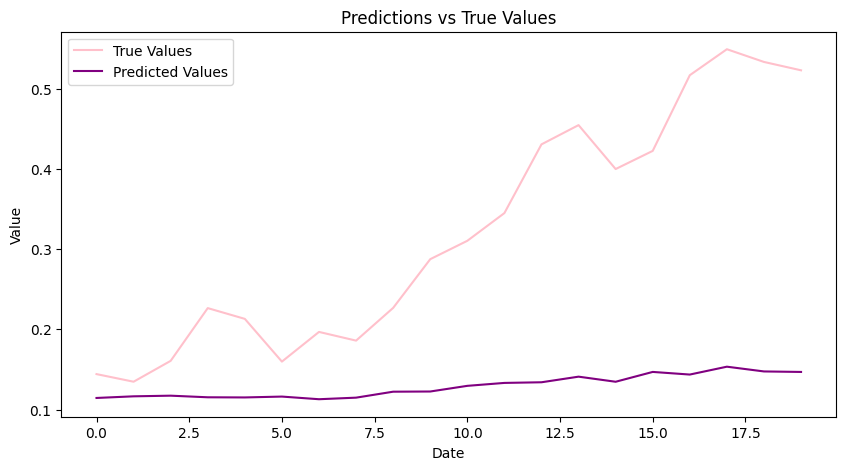

In [ ]:
builder2.graph_history(hist_lstm2_3)
y_true, predictions = builder2.predict(model_lstm2_3)
builder2.calculate_metrics(y_true, predictions)
builder2.graph_prediction(y_true, predictions)

In [281]:
model_lstm2_4, hist_lstm2_4 = builder2.create_LSTM_model(num_neurons=64, epochs=125,
                                                  dropout_rate=0.2, use_recurrent_dropout=False,
                                                  name_model="LSTM2_4_64")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.6759 - mae: 0.6331 - val_loss: 0.1384 - val_mae: 0.3117
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.4511 - mae: 0.5438 - val_loss: 0.1446 - val_mae: 0.3194
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.4218 - mae: 0.5266 - val_loss: 0.1421 - val_mae: 0.3160
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.4018 - mae: 0.5143 - val_loss: 0.1375 - val_mae: 0.3104
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.3744 - mae: 0.4987 - val_loss: 0.1287 - val_mae: 0.2994
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.3451 - mae: 0.4815 - val_loss: 0.1191 - val_mae: 0.2870
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.3391 - mae: 0.4778 - val_loss: 0.1145 - val_mae: 0.2809
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.3239 - mae: 0.4668 - val_loss: 0.1098 - val_mae: 0.2741
Epoch 9/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - lo

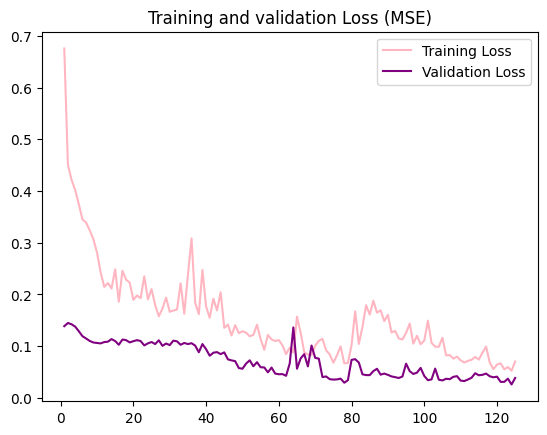

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step
MAE: 0.2993
MSE: 0.1362
RMSE: 0.3690


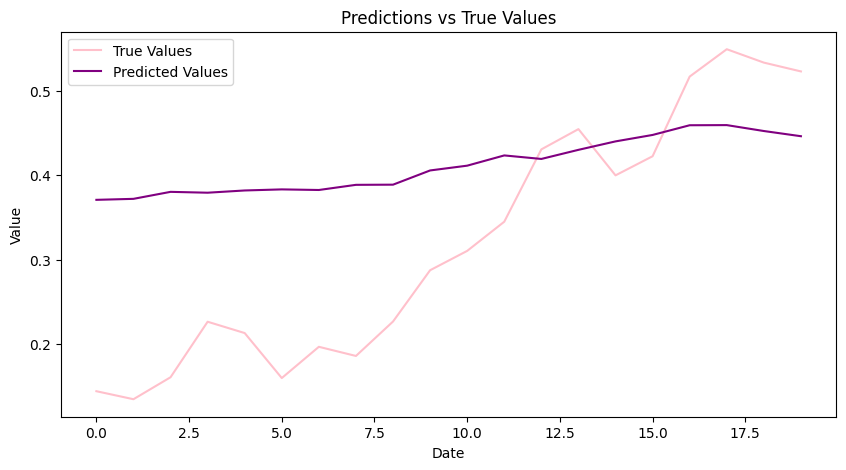

In [ ]:
builder2.graph_history(hist_lstm2_4)
y_true, predictions = builder2.predict(model_lstm2_4)
builder2.calculate_metrics(y_true, predictions)
builder2.graph_prediction(y_true, predictions)

In [283]:
model_lstm3_1, hist_lstm3_1 = builder3.create_LSTM_model(num_neurons=64, epochs=150,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM3_1_64")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - loss: 0.5843 - mae: 0.5920 - val_loss: 0.2384 - val_mae: 0.4191
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.5779 - mae: 0.6022 - val_loss: 0.2540 - val_mae: 0.4319
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 0.5431 - mae: 0.5832 - val_loss: 0.2706 - val_mae: 0.4448
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.5378 - mae: 0.5808 - val_loss: 0.2772 - val_mae: 0.4499
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 0.5166 - mae: 0.5726 - val_loss: 0.2918 - val_mae: 0.4616
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 0.4952 - mae: 0.5649 - val_loss: 0.2980 - val_mae: 0.4666
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 0.4695 - mae: 0.5542 - val_loss: 0.3058 - val_mae: 0.4729
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.4510 - mae: 0.5459 - val_loss: 0.2948 - val_mae: 0.4646
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms

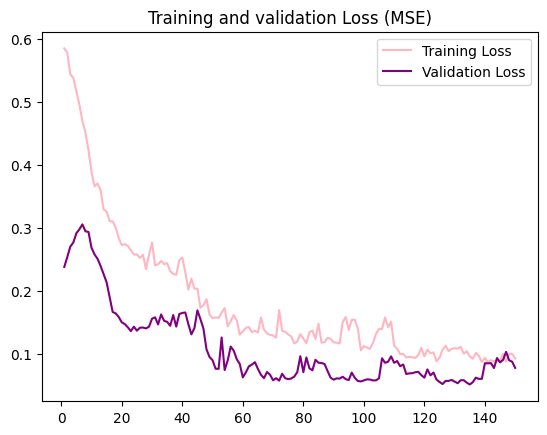

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
MAE: 0.4180
MSE: 0.2437
RMSE: 0.4936


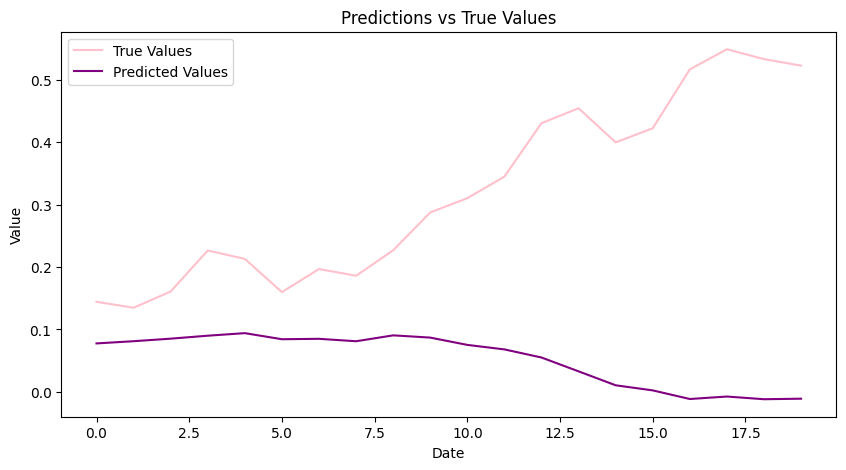

In [ ]:
builder3.graph_history(hist_lstm3_1)
y_true, predictions = builder3.predict(model_lstm3_1)
builder3.calculate_metrics(y_true, predictions)
builder3.graph_prediction(y_true, predictions)

In [285]:
model_lstm3_2, hist_lstm3_2 = builder3.create_LSTM_model(num_neurons=128, epochs=150,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM3_2_128")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - loss: 0.6407 - mae: 0.5860 - val_loss: 0.2574 - val_mae: 0.4336
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 0.5689 - mae: 0.5995 - val_loss: 0.2891 - val_mae: 0.4594
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 0.5580 - mae: 0.5944 - val_loss: 0.2904 - val_mae: 0.4601
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - loss: 0.5515 - mae: 0.5919 - val_loss: 0.2768 - val_mae: 0.4497
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 0.5260 - mae: 0.5819 - val_loss: 0.2889 - val_mae: 0.4587
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.4813 - mae: 0.5571 - val_loss: 0.2684 - val_mae: 0.4404
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.4230 - mae: 0.5250 - val_loss: 0.2204 - val_mae: 0.3961
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 0.4564 - mae: 0.5204 - val_loss: 0.2341 - val_mae: 0.4078
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/

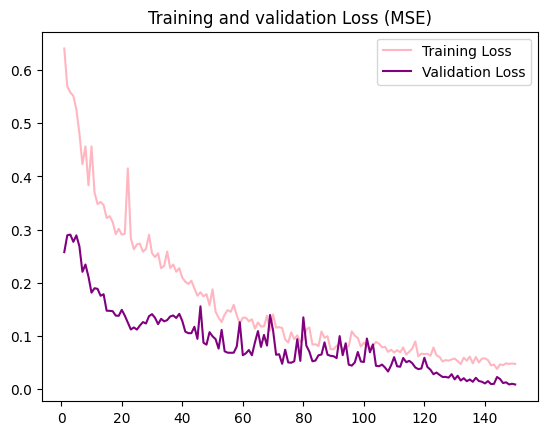

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
MAE: 0.3745
MSE: 0.2406
RMSE: 0.4905


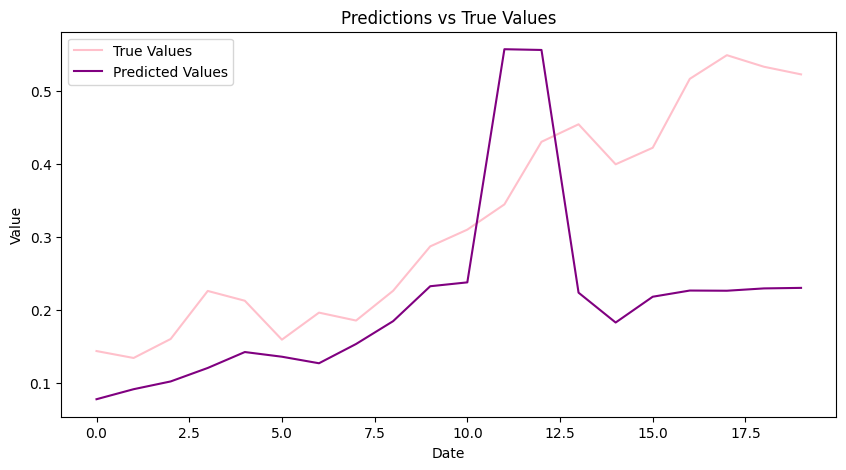

In [ ]:
builder3.graph_history(hist_lstm3_2)
y_true, predictions = builder3.predict(model_lstm3_2)
builder3.calculate_metrics(y_true, predictions)
builder3.graph_prediction(y_true, predictions)

In [287]:
model_lstm3_3, hist_lstm3_3 = builder3.create_LSTM_model(num_neurons=32, epochs=150,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM3_3_32")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.8982 - mae: 0.7177 - val_loss: 0.1781 - val_mae: 0.3491
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6525 - mae: 0.6233 - val_loss: 0.2114 - val_mae: 0.3868
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.5781 - mae: 0.5973 - val_loss: 0.2445 - val_mae: 0.4222
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.5500 - mae: 0.5881 - val_loss: 0.2664 - val_mae: 0.4429
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.5335 - mae: 0.5794 - val_loss: 0.2812 - val_mae: 0.4550
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.5265 - mae: 0.5766 - val_loss: 0.2901 - val_mae: 0.4620
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.5226 - mae: 0.5738 - val_loss: 0.2964 - val_mae: 0.4666
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.5112 - mae: 0.5678 - val_loss: 0.3036 - val_mae: 0.4718
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - lo

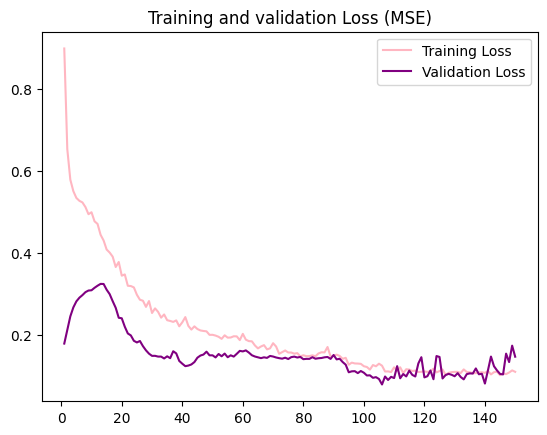

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
MAE: 0.3787
MSE: 0.1973
RMSE: 0.4442


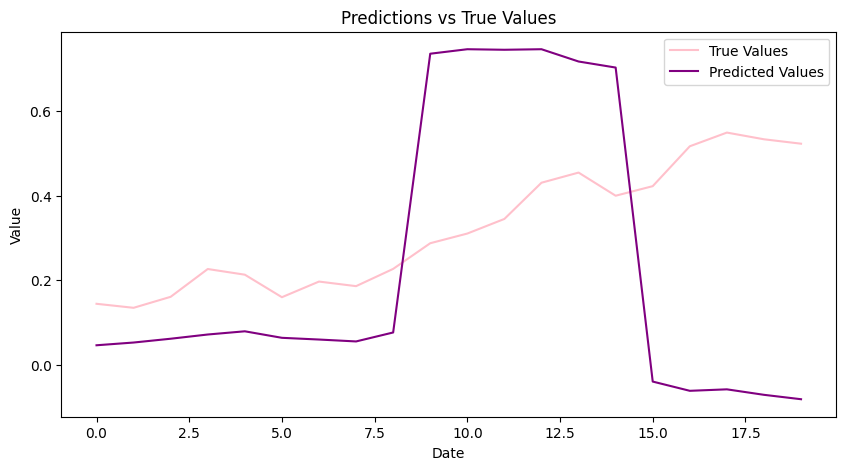

In [ ]:
builder3.graph_history(hist_lstm3_3)
y_true, predictions = builder3.predict(model_lstm3_3)
builder3.calculate_metrics(y_true, predictions)
builder3.graph_prediction(y_true, predictions)

In [289]:
model_lstm3_4, hist_lstm3_4 = builder3.create_LSTM_model(num_neurons=128, epochs=150,
                                                  dropout_rate=0.2, use_recurrent_dropout=False,
                                                  name_model="LSTM3_4_128")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.6445 - mae: 0.5785 - val_loss: 0.2629 - val_mae: 0.4391
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - loss: 0.5771 - mae: 0.6097 - val_loss: 0.2873 - val_mae: 0.4594
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - loss: 0.5573 - mae: 0.5956 - val_loss: 0.2850 - val_mae: 0.4569
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - loss: 0.5441 - mae: 0.5877 - val_loss: 0.2761 - val_mae: 0.4495
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.5182 - mae: 0.5761 - val_loss: 0.2764 - val_mae: 0.4496
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 0.5024 - mae: 0.5744 - val_loss: 0.2821 - val_mae: 0.4531
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 0.4680 - mae: 0.5448 - val_loss: 0.2908 - val_mae: 0.4430
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 0.4093 - mae: 0.5051 - val_loss: 0.2163 - val_mae: 0.3834
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/

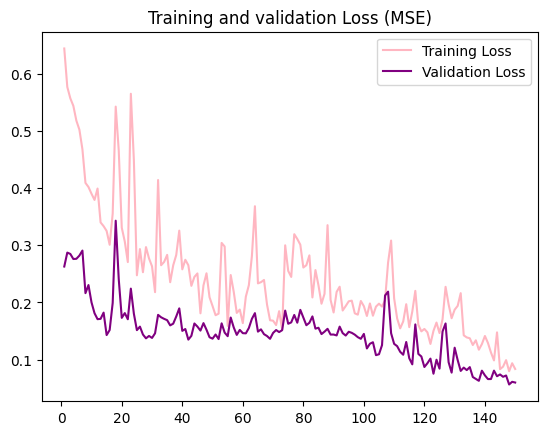

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
MAE: 0.3483
MSE: 0.1830
RMSE: 0.4278


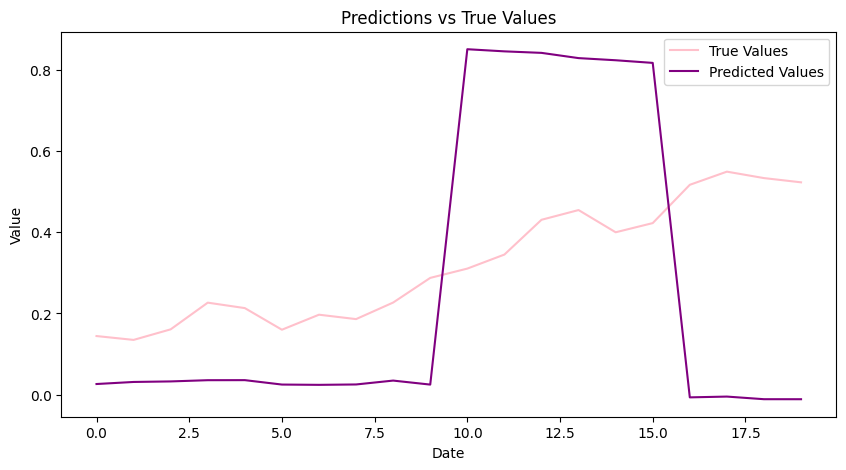

In [ ]:
builder3.graph_history(hist_lstm3_4)
y_true, predictions = builder3.predict(model_lstm3_4)
builder3.calculate_metrics(y_true, predictions)
builder3.graph_prediction(y_true, predictions)

# Punto 3

In [291]:
model_gru1_1, hist_gru1_1 = builder.create_GRU_model(num_neurons=32, epochs=100,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU1_1_32")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.2566 - mae: 0.3840 - val_loss: 0.1068 - val_mae: 0.2604
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2486 - mae: 0.3783 - val_loss: 0.1059 - val_mae: 0.2564
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2398 - mae: 0.3723 - val_loss: 0.1054 - val_mae: 0.2546
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2387 - mae: 0.3704 - val_loss: 0.1034 - val_mae: 0.2522
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2346 - mae: 0.3673 - val_loss: 0.1018 - val_mae: 0.2500
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2294 - mae: 0.3653 - val_loss: 0.1006 - val_mae: 0.2483
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2227 - mae: 0.3581 - val_loss: 0.1000 - val_mae: 0.2468
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2211 - mae: 0.3560 - val_loss: 0.0979 - val_mae: 0.2444
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

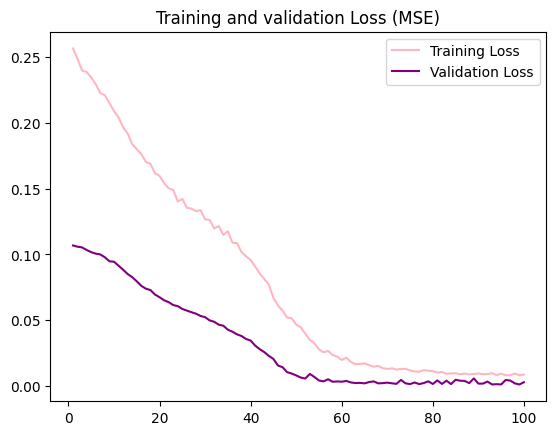

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
MAE: 0.0516
MSE: 0.0059
RMSE: 0.0768


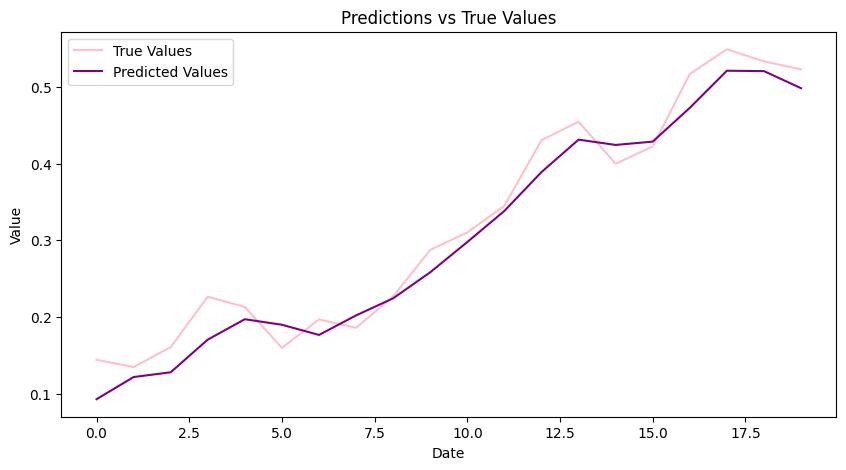

In [292]:
builder.graph_history(hist_gru1_1)
y_trueG,predictionsG = builder.predict(model_gru1_1)
builder.calculate_metrics(y_trueG, predictionsG)
builder.graph_prediction(y_trueG,predictionsG)

In [293]:
model_gru1_2, hist_gru1_2 = builder.create_GRU_model(num_neurons=64, epochs=100,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU1_2_64")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.2626 - mae: 0.3971 - val_loss: 0.1085 - val_mae: 0.2658
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2453 - mae: 0.3774 - val_loss: 0.1041 - val_mae: 0.2568
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2417 - mae: 0.3745 - val_loss: 0.1046 - val_mae: 0.2562
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2372 - mae: 0.3694 - val_loss: 0.1029 - val_mae: 0.2537
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2323 - mae: 0.3651 - val_loss: 0.1018 - val_mae: 0.2523
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2304 - mae: 0.3628 - val_loss: 0.1017 - val_mae: 0.2509
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2239 - mae: 0.3588 - val_loss: 0.0991 - val_mae: 0.2481
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2172 - mae: 0.3534 - val_loss: 0.0983 - val_mae: 0.2465
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - lo

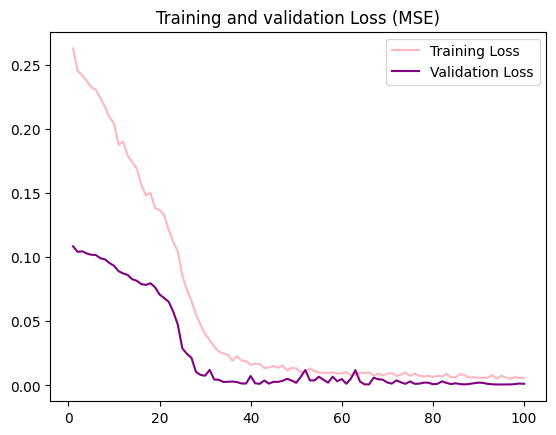

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
MAE: 0.0370
MSE: 0.0025
RMSE: 0.0501


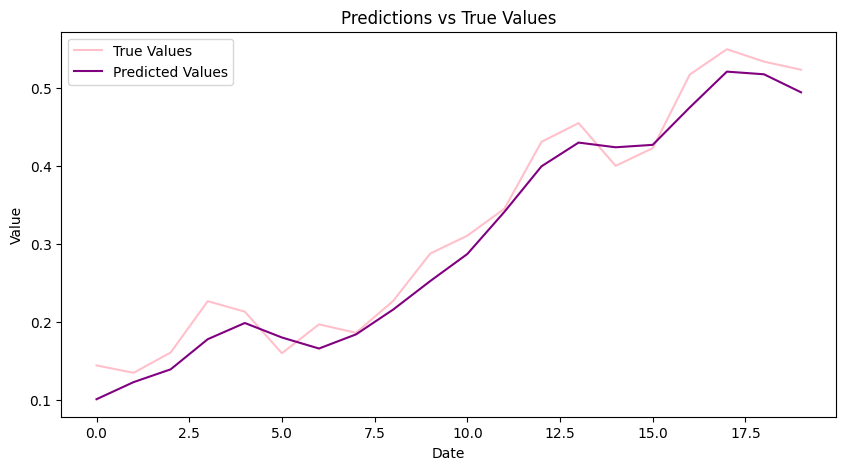

In [294]:
builder.graph_history(hist_gru1_2)
y_trueG,predictionsG = builder.predict(model_gru1_2)
builder.calculate_metrics(y_trueG, predictionsG)
builder.graph_prediction(y_trueG,predictionsG)

In [295]:
model_gru1_3, hist_gru1_3 = builder.create_GRU_model(num_neurons=128, epochs=100,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU1_3_128")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2551 - mae: 0.3827 - val_loss: 0.0987 - val_mae: 0.2546
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2476 - mae: 0.3776 - val_loss: 0.0978 - val_mae: 0.2508
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2422 - mae: 0.3739 - val_loss: 0.0978 - val_mae: 0.2505
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2417 - mae: 0.3718 - val_loss: 0.0978 - val_mae: 0.2504
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2352 - mae: 0.3683 - val_loss: 0.0978 - val_mae: 0.2489
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2287 - mae: 0.3623 - val_loss: 0.0956 - val_mae: 0.2457
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2239 - mae: 0.3582 - val_loss: 0.0934 - val_mae: 0.2425
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2152 - mae: 0.3522 - val_loss: 0.0897 - val_mae: 0.2372
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - lo

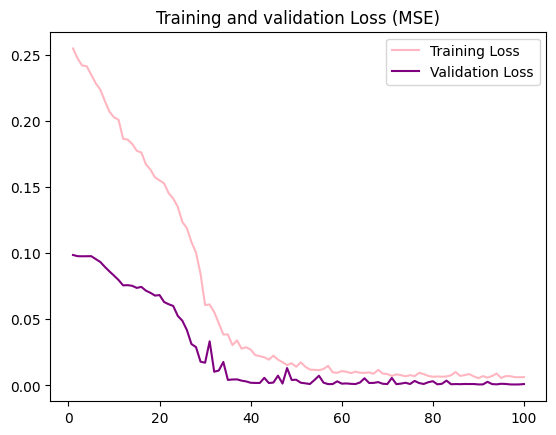

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
MAE: 0.0430
MSE: 0.0037
RMSE: 0.0607


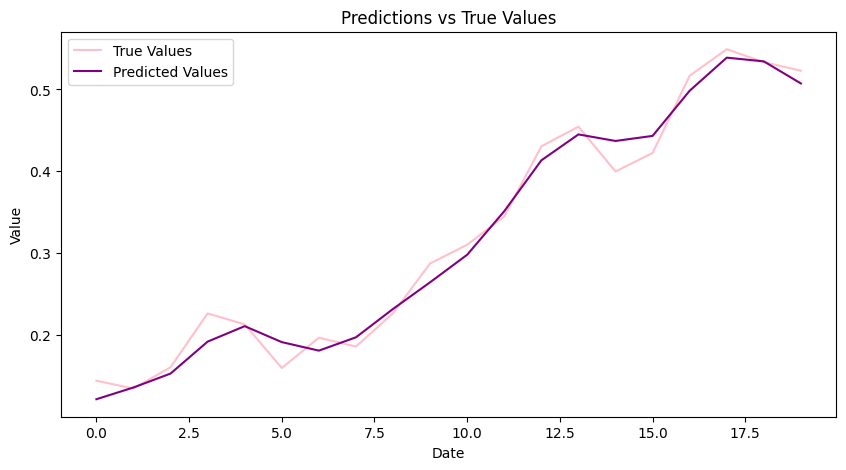

In [296]:
builder.graph_history(hist_gru1_3)
y_trueG,predictionsG = builder.predict(model_gru1_3)
builder.calculate_metrics(y_trueG, predictionsG)
builder.graph_prediction(y_trueG,predictionsG)

In [297]:
model_gru1_4, hist_gru1_4 = builder.create_GRU_model(num_neurons=128, epochs=100,
                                               dropout_rate=0.2, use_recurrent_dropout=False,
                                               name_model="GRU1_4_128")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.2499 - mae: 0.3761 - val_loss: 0.0996 - val_mae: 0.2550
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2434 - mae: 0.3744 - val_loss: 0.0985 - val_mae: 0.2520
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2400 - mae: 0.3707 - val_loss: 0.0985 - val_mae: 0.2511
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.2358 - mae: 0.3675 - val_loss: 0.0978 - val_mae: 0.2494
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2307 - mae: 0.3638 - val_loss: 0.0964 - val_mae: 0.2466
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2237 - mae: 0.3583 - val_loss: 0.0933 - val_mae: 0.2413
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2139 - mae: 0.3500 - val_loss: 0.0878 - val_mae: 0.2317
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.2010 - mae: 0.3362 - val_loss: 0.0802 - val_mae: 0.2171
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - lo

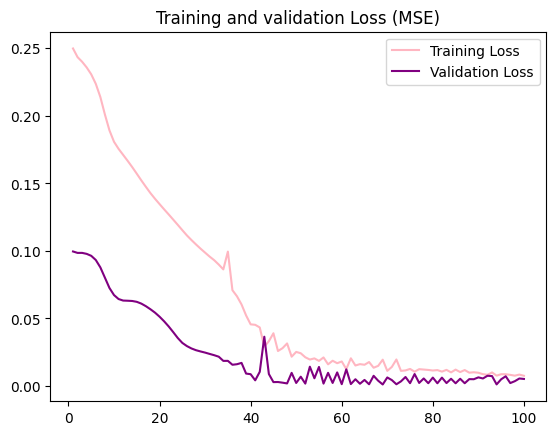

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
MAE: 0.1346
MSE: 0.0396
RMSE: 0.1990


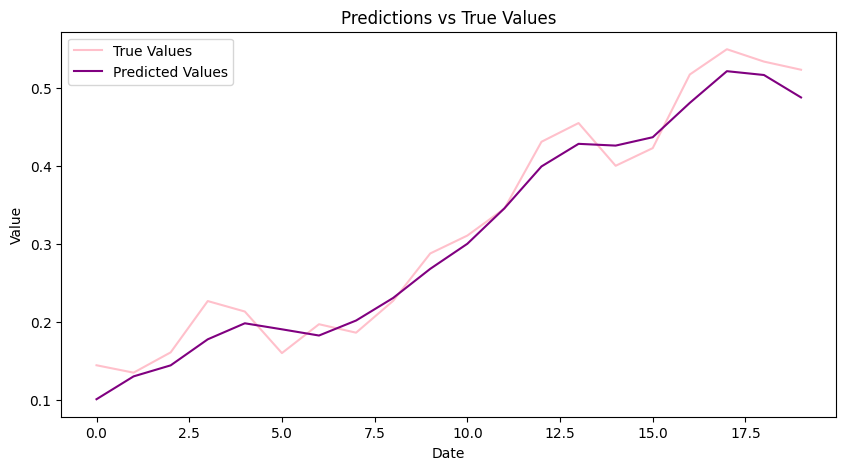

In [298]:
builder.graph_history(hist_gru1_4)
y_trueG,predictionsG = builder.predict(model_gru1_4)
builder.calculate_metrics(y_trueG, predictionsG)
builder.graph_prediction(y_trueG,predictionsG)

In [299]:
model_gru2_1, hist_gru2_1 = builder2.create_GRU_model(num_neurons=32, epochs=125,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU2_1_32")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.5190 - mae: 0.5790 - val_loss: 0.1657 - val_mae: 0.3415
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.4608 - mae: 0.5498 - val_loss: 0.1748 - val_mae: 0.3517
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.4545 - mae: 0.5458 - val_loss: 0.1795 - val_mae: 0.3558
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4466 - mae: 0.5395 - val_loss: 0.1824 - val_mae: 0.3582
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4468 - mae: 0.5398 - val_loss: 0.1829 - val_mae: 0.3584
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4412 - mae: 0.5373 - val_loss: 0.1831 - val_mae: 0.3584
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4359 - mae: 0.5348 - val_loss: 0.1831 - val_mae: 0.3584
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4353 - mae: 0.5355 - val_loss: 0.1812 - val_mae: 0.3565
Epoch 9/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - lo

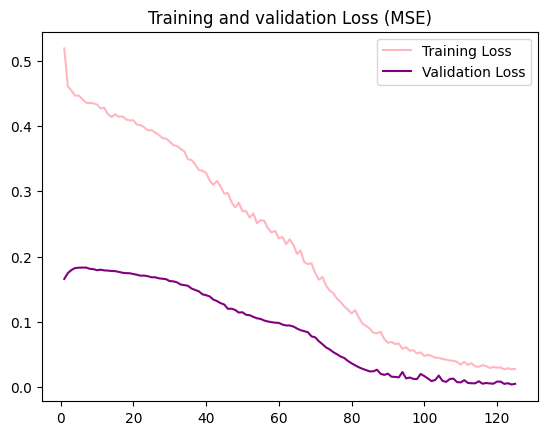

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
MAE: 0.1267
MSE: 0.0322
RMSE: 0.1794


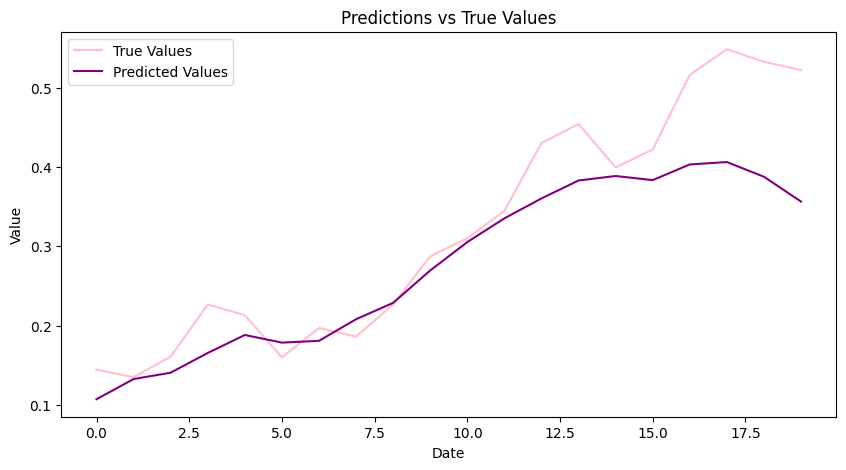

In [300]:
builder2.graph_history(hist_gru2_1)
y_trueG,predictionsG = builder2.predict(model_gru2_1)
builder2.calculate_metrics(y_trueG, predictionsG)
builder2.graph_prediction(y_trueG,predictionsG)

In [301]:
model_gru2_2, hist_gru2_2 = builder2.create_GRU_model(num_neurons=64, epochs=125,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU2_2_64")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.4799 - mae: 0.5467 - val_loss: 0.1645 - val_mae: 0.3396
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4639 - mae: 0.5485 - val_loss: 0.1662 - val_mae: 0.3431
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4622 - mae: 0.5467 - val_loss: 0.1683 - val_mae: 0.3450
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4556 - mae: 0.5437 - val_loss: 0.1711 - val_mae: 0.3474
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4444 - mae: 0.5384 - val_loss: 0.1725 - val_mae: 0.3486
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4464 - mae: 0.5393 - val_loss: 0.1717 - val_mae: 0.3477
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.4431 - mae: 0.5364 - val_loss: 0.1727 - val_mae: 0.3487
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4387 - mae: 0.5359 - val_loss: 0.1720 - val_mae: 0.3480
Epoch 9/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - lo

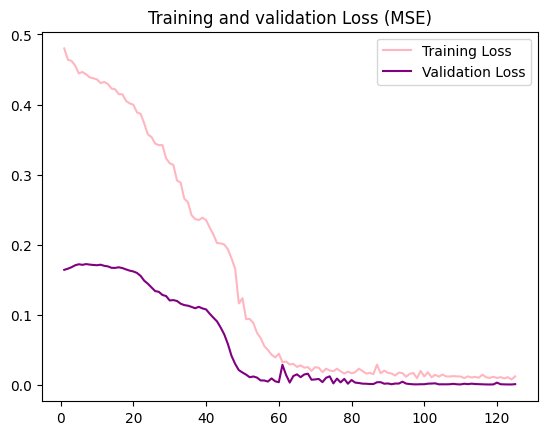

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
MAE: 0.0558
MSE: 0.0059
RMSE: 0.0770


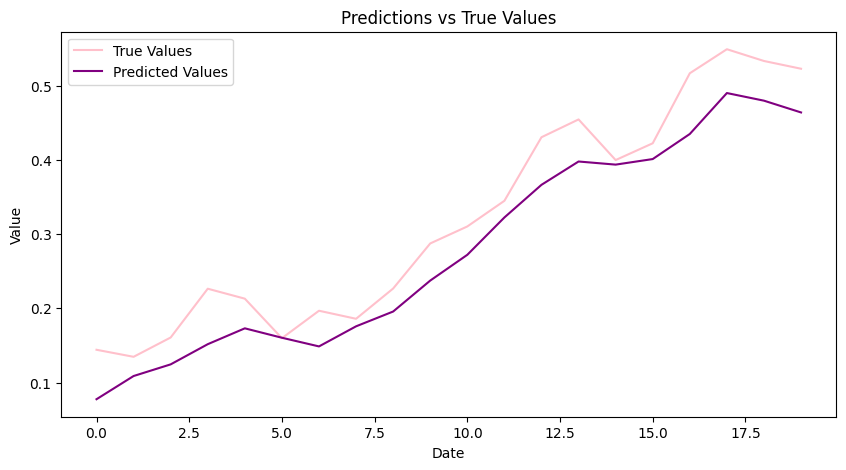

In [302]:
builder2.graph_history(hist_gru2_2)
y_trueG,predictionsG = builder2.predict(model_gru2_2)
builder2.calculate_metrics(y_trueG, predictionsG)
builder2.graph_prediction(y_trueG,predictionsG)

In [303]:
model_gru2_3, hist_gru2_3 = builder2.create_GRU_model(num_neurons=128, epochs=125,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU2_3_128")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.4855 - mae: 0.5543 - val_loss: 0.1693 - val_mae: 0.3453
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.4677 - mae: 0.5544 - val_loss: 0.1683 - val_mae: 0.3451
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.4673 - mae: 0.5522 - val_loss: 0.1680 - val_mae: 0.3446
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.4631 - mae: 0.5480 - val_loss: 0.1703 - val_mae: 0.3467
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.4637 - mae: 0.5499 - val_loss: 0.1690 - val_mae: 0.3454
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.4639 - mae: 0.5495 - val_loss: 0.1687 - val_mae: 0.3450
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.4561 - mae: 0.5450 - val_loss: 0.1692 - val_mae: 0.3455
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.4521 - mae: 0.5429 - val_loss: 0.1685 - val_mae: 0.3447
Epoch 9/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - lo

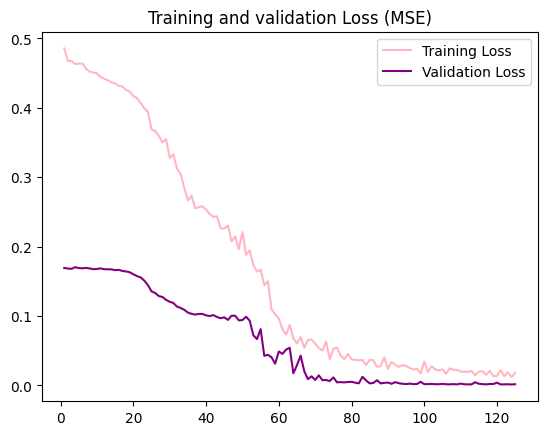

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
MAE: 0.0663
MSE: 0.0089
RMSE: 0.0942


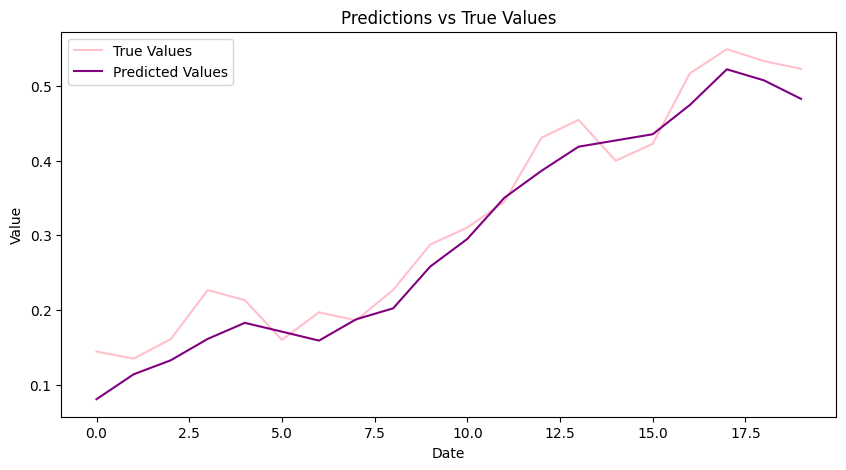

In [304]:
builder2.graph_history(hist_gru2_3)
y_trueG,predictionsG = builder2.predict(model_gru2_3)
builder2.calculate_metrics(y_trueG, predictionsG)
builder2.graph_prediction(y_trueG,predictionsG)

In [305]:
model_gru2_4, hist_gru2_4 = builder2.create_GRU_model(num_neurons=128, epochs=125,
                                               dropout_rate=0.2, use_recurrent_dropout=False,
                                               name_model="GRU2_4_128")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.4594 - mae: 0.5476 - val_loss: 0.1743 - val_mae: 0.3505
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.4681 - mae: 0.5558 - val_loss: 0.1731 - val_mae: 0.3497
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.4624 - mae: 0.5505 - val_loss: 0.1740 - val_mae: 0.3501
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.4588 - mae: 0.5480 - val_loss: 0.1743 - val_mae: 0.3502
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.4562 - mae: 0.5464 - val_loss: 0.1740 - val_mae: 0.3498
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.4537 - mae: 0.5451 - val_loss: 0.1738 - val_mae: 0.3496
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.4512 - mae: 0.5436 - val_loss: 0.1732 - val_mae: 0.3489
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.4489 - mae: 0.5423 - val_loss: 0.1727 - val_mae: 0.3483
Epoch 9/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - lo

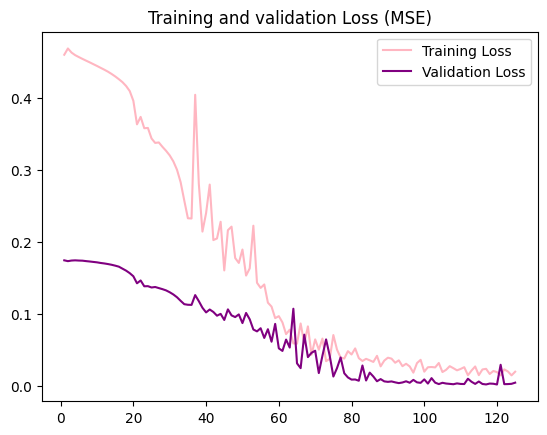

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
MAE: 0.1201
MSE: 0.0314
RMSE: 0.1771


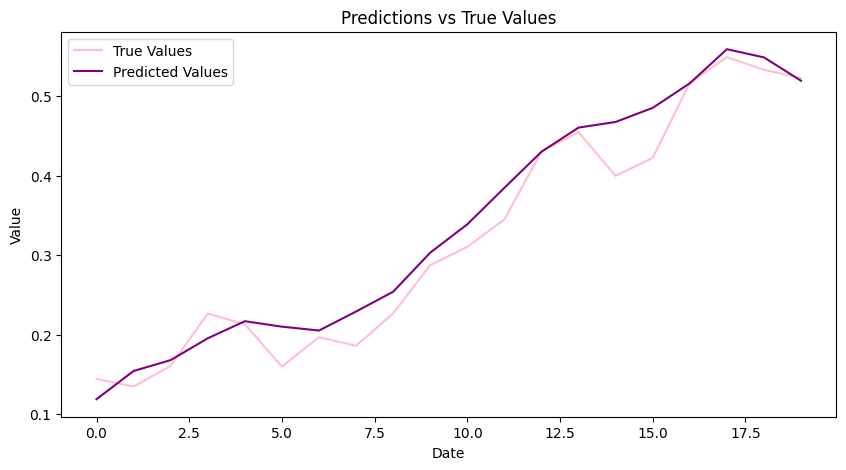

In [306]:
builder2.graph_history(hist_gru2_4)
y_trueG,predictionsG = builder2.predict(model_gru2_4)
builder2.calculate_metrics(y_trueG, predictionsG)
builder2.graph_prediction(y_trueG,predictionsG)

In [307]:
model_gru3_1, hist_gru3_1 = builder3.create_GRU_model(num_neurons=32, epochs=150,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU3_1_32")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 1.0173 - mae: 0.7565 - val_loss: 0.1736 - val_mae: 0.3428
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6524 - mae: 0.6044 - val_loss: 0.1937 - val_mae: 0.3659
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.5550 - mae: 0.5697 - val_loss: 0.2217 - val_mae: 0.3970
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.5356 - mae: 0.5636 - val_loss: 0.2419 - val_mae: 0.4169
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.5309 - mae: 0.5646 - val_loss: 0.2549 - val_mae: 0.4283
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.5304 - mae: 0.5657 - val_loss: 0.2643 - val_mae: 0.4362
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.5261 - mae: 0.5651 - val_loss: 0.2706 - val_mae: 0.4412
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.5326 - mae: 0.5679 - val_loss: 0.2723 - val_mae: 0.4422
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - lo

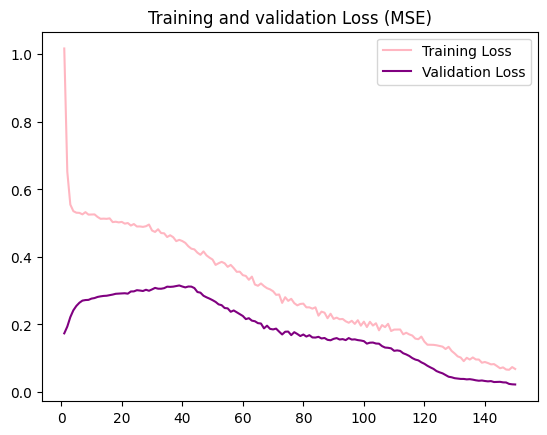

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
MAE: 0.2282
MSE: 0.0987
RMSE: 0.3142


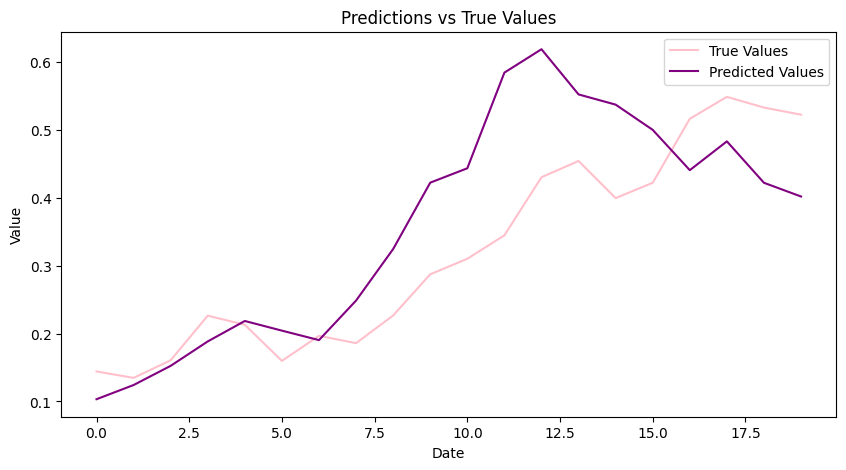

In [308]:
builder3.graph_history(hist_gru3_1)
y_trueG,predictionsG = builder3.predict(model_gru3_1)
builder3.calculate_metrics(y_trueG, predictionsG)
builder3.graph_prediction(y_trueG,predictionsG)

In [309]:
model_gru3_2, hist_gru3_2 = builder3.create_GRU_model(num_neurons=64, epochs=150,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU3_2_64")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.6558 - mae: 0.6233 - val_loss: 0.2331 - val_mae: 0.4052
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.5783 - mae: 0.5890 - val_loss: 0.2459 - val_mae: 0.4194
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.5677 - mae: 0.5852 - val_loss: 0.2565 - val_mae: 0.4285
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.5608 - mae: 0.5812 - val_loss: 0.2628 - val_mae: 0.4336
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.5532 - mae: 0.5782 - val_loss: 0.2723 - val_mae: 0.4410
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.5505 - mae: 0.5764 - val_loss: 0.2766 - val_mae: 0.4440
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.5445 - mae: 0.5749 - val_loss: 0.2830 - val_mae: 0.4488
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.5444 - mae: 0.5753 - val_loss: 0.2874 - val_mae: 0.4519
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - lo

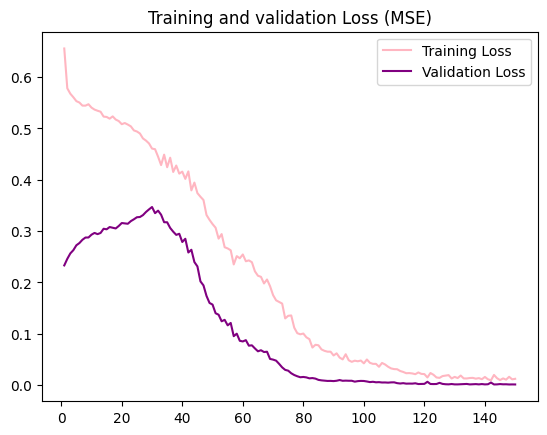

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
MAE: 0.0966
MSE: 0.0182
RMSE: 0.1349


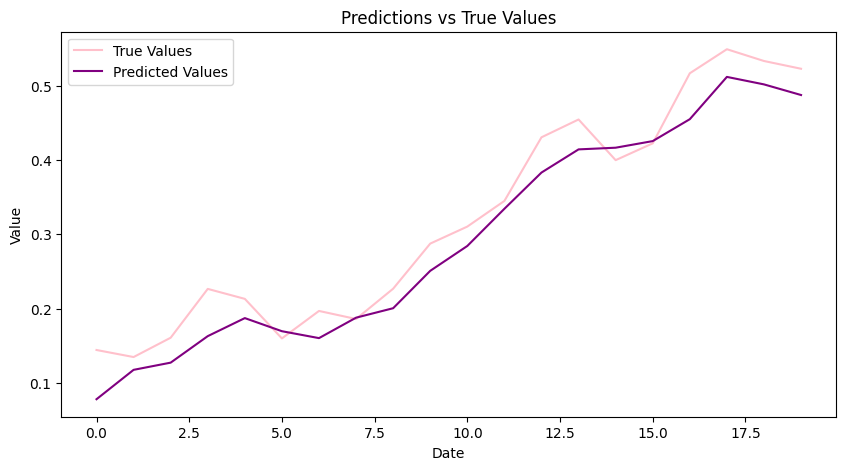

In [310]:
builder3.graph_history(hist_gru3_2)
y_trueG,predictionsG = builder3.predict(model_gru3_2)
builder3.calculate_metrics(y_trueG, predictionsG)
builder3.graph_prediction(y_trueG,predictionsG)

In [311]:
model_gru3_3, hist_gru3_3 = builder3.create_GRU_model(num_neurons=128, epochs=150,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU3_3_128")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 0.7361 - mae: 0.6615 - val_loss: 0.2588 - val_mae: 0.4306
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.5938 - mae: 0.5974 - val_loss: 0.2697 - val_mae: 0.4389
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.5780 - mae: 0.5900 - val_loss: 0.2850 - val_mae: 0.4502
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.5772 - mae: 0.5902 - val_loss: 0.2848 - val_mae: 0.4495
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.5681 - mae: 0.5868 - val_loss: 0.2889 - val_mae: 0.4525
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.5640 - mae: 0.5848 - val_loss: 0.2905 - val_mae: 0.4535
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.5575 - mae: 0.5823 - val_loss: 0.2946 - val_mae: 0.4567
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.5553 - mae: 0.5810 - val_loss: 0.2940 - val_mae: 0.4562
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/

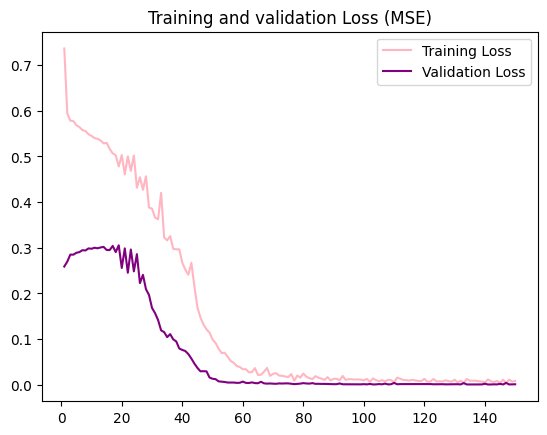

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
MAE: 0.0493
MSE: 0.0049
RMSE: 0.0699


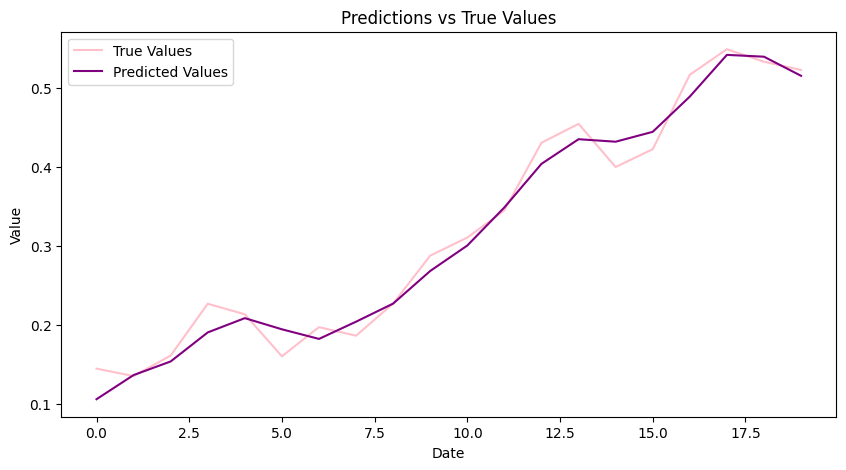

In [312]:
builder3.graph_history(hist_gru3_3)
y_trueG,predictionsG = builder3.predict(model_gru3_3)
builder3.calculate_metrics(y_trueG, predictionsG)
builder3.graph_prediction(y_trueG,predictionsG)

In [313]:
model_gru3_4, hist_gru3_4 = builder3.create_GRU_model(num_neurons=128, epochs=150,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU3_4_128")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.5382 - mae: 0.5562 - val_loss: 0.3013 - val_mae: 0.4635
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.6011 - mae: 0.6054 - val_loss: 0.2765 - val_mae: 0.4433
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.5715 - mae: 0.5883 - val_loss: 0.2844 - val_mae: 0.4488
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.5673 - mae: 0.5878 - val_loss: 0.2852 - val_mae: 0.4492
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.5612 - mae: 0.5831 - val_loss: 0.2890 - val_mae: 0.4520
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.5574 - mae: 0.5817 - val_loss: 0.2921 - val_mae: 0.4545
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.5570 - mae: 0.5824 - val_loss: 0.2879 - val_mae: 0.4512
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.5490 - mae: 0.5776 - val_loss: 0.2898 - val_mae: 0.4527
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/

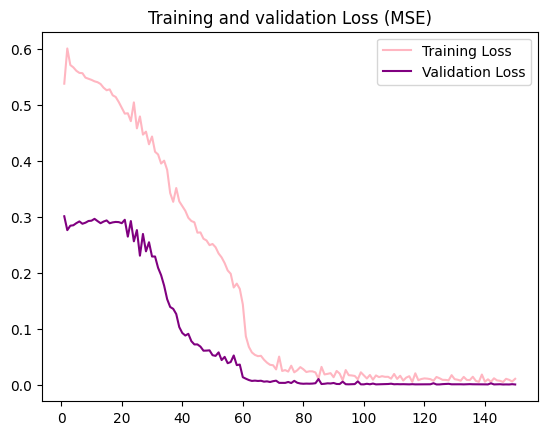

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
MAE: 0.0490
MSE: 0.0042
RMSE: 0.0649


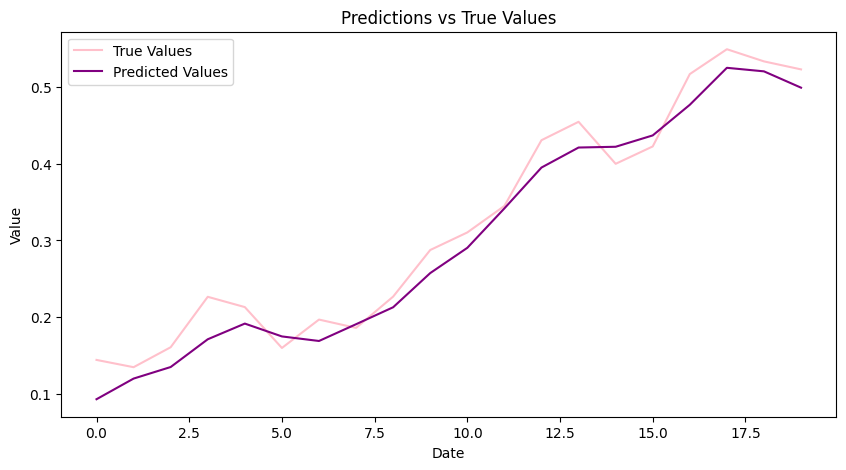

In [314]:
builder3.graph_history(hist_gru3_4)
y_trueG,predictionsG = builder3.predict(model_gru3_4)
builder3.calculate_metrics(y_trueG, predictionsG)
builder3.graph_prediction(y_trueG,predictionsG)

# Punto 4

In [315]:
model_stack1_1, hist_stack1_1 = builder.create_stacked_GRU(num_l1=64, num_l2=32, epochs=50,
                                                     name_model="Stacked_GRU1_1_64_32")

Epoch 1/50


c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - loss: 0.2297 - mae: 0.3688 - val_loss: 0.0959 - val_mae: 0.2512
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.2272 - mae: 0.3655 - val_loss: 0.0938 - val_mae: 0.2461
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2218 - mae: 0.3593 - val_loss: 0.0929 - val_mae: 0.2432
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.2163 - mae: 0.3539 - val_loss: 0.0917 - val_mae: 0.2405
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2107 - mae: 0.3485 - val_loss: 0.0903 - val_mae: 0.2378
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2047 - mae: 0.3423 - val_loss: 0.0885 - val_mae: 0.2347
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1981 - mae: 0.3352 - val_loss: 0.0862 - val_mae: 0.2310
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1914 - mae: 0.3274 - val_loss: 0.0839 - val_mae: 0.2272
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1847 - mae: 0

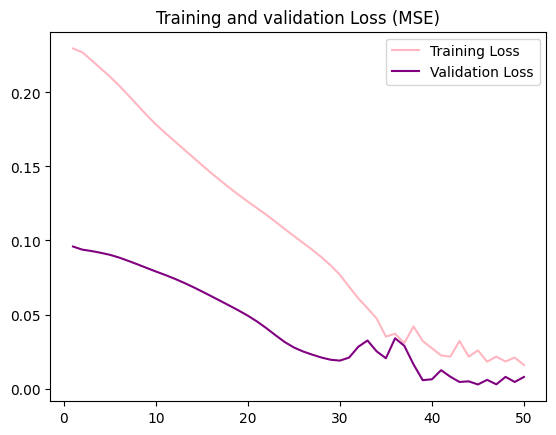

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
MAE: 0.1614
MSE: 0.0573
RMSE: 0.2394


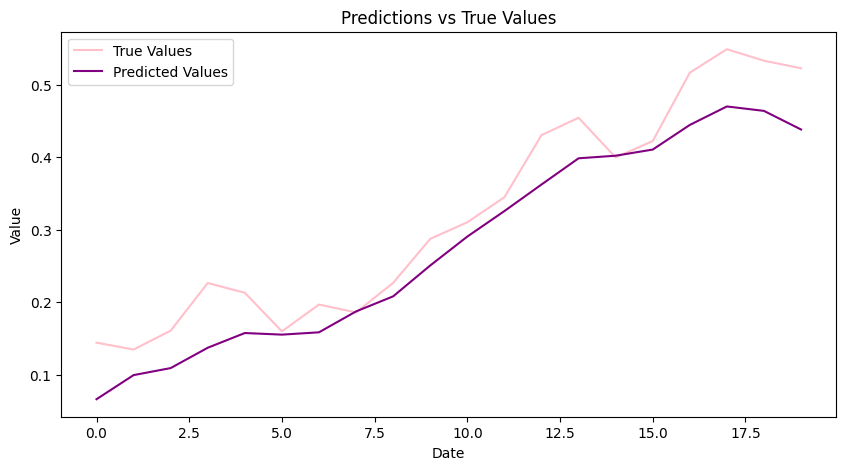

In [316]:
builder.graph_history(hist_stack1_1)
y_trueS,predictionsS = builder.predict(model_stack1_1)
builder.calculate_metrics(y_trueS, predictionsS)
builder.graph_prediction(y_trueS,predictionsS)

In [317]:
model_stack1_2, hist_stack1_2 = builder.create_stacked_GRU(num_l1=128, num_l2=32, epochs=50,
                                                     name_model="Stacked_GRU1_2_128_32")

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.2593 - mae: 0.3870 - val_loss: 0.0953 - val_mae: 0.2505
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.2398 - mae: 0.3711 - val_loss: 0.0927 - val_mae: 0.2454
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2319 - mae: 0.3642 - val_loss: 0.0912 - val_mae: 0.2421
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.2252 - mae: 0.3573 - val_loss: 0.0899 - val_mae: 0.2384
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.2168 - mae: 0.3489 - val_loss: 0.0879 - val_mae: 0.2341
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2091 - mae: 0.3396 - val_loss: 0.0855 - val_mae: 0.2294
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2011 - mae: 0.3302 - val_loss: 0.0837 - val_mae: 0.2256
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1935 - mae: 0.3223 - val_loss: 0.0819 - val_mae: 0.2225
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.186

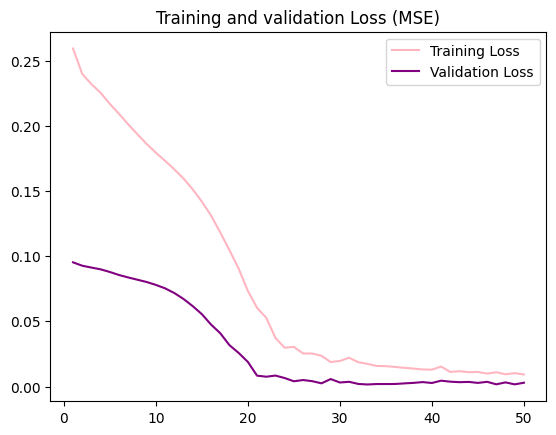

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
MAE: 0.1411
MSE: 0.0496
RMSE: 0.2226


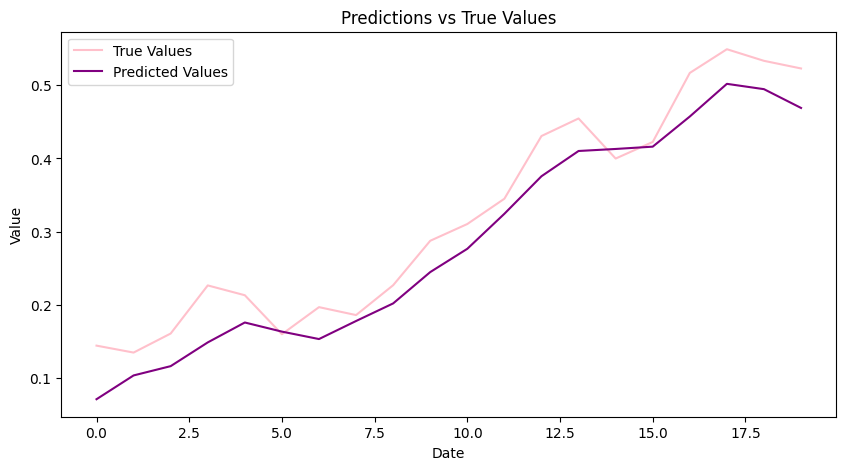

In [318]:
builder.graph_history(hist_stack1_2)
y_trueS,predictionsS = builder.predict(model_stack1_2)
builder.calculate_metrics(y_trueS, predictionsS)
builder.graph_prediction(y_trueS,predictionsS)

In [319]:
model_stack1_3, hist_stack1_3 = builder.create_stacked_GRU(num_l1=128, num_l2=64, epochs=50,
                                                     name_model="Stacked_GRU1_3_128_64")

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.2570 - mae: 0.3826 - val_loss: 0.0946 - val_mae: 0.2516
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2413 - mae: 0.3738 - val_loss: 0.0925 - val_mae: 0.2458
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.2342 - mae: 0.3669 - val_loss: 0.0920 - val_mae: 0.2432
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.2287 - mae: 0.3615 - val_loss: 0.0909 - val_mae: 0.2397
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2243 - mae: 0.3559 - val_loss: 0.0893 - val_mae: 0.2355
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.2209 - mae: 0.3493 - val_loss: 0.0864 - val_mae: 0.2294
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.2140 - mae: 0.3395 - val_loss: 0.0836 - val_mae: 0.2235
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.2061 - mae: 0.3300 - val_loss: 0.0821 - val_mae: 0.2202
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.199

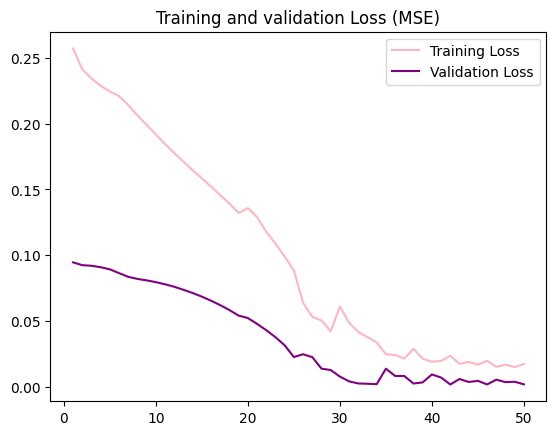

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
MAE: 0.1657
MSE: 0.0536
RMSE: 0.2316


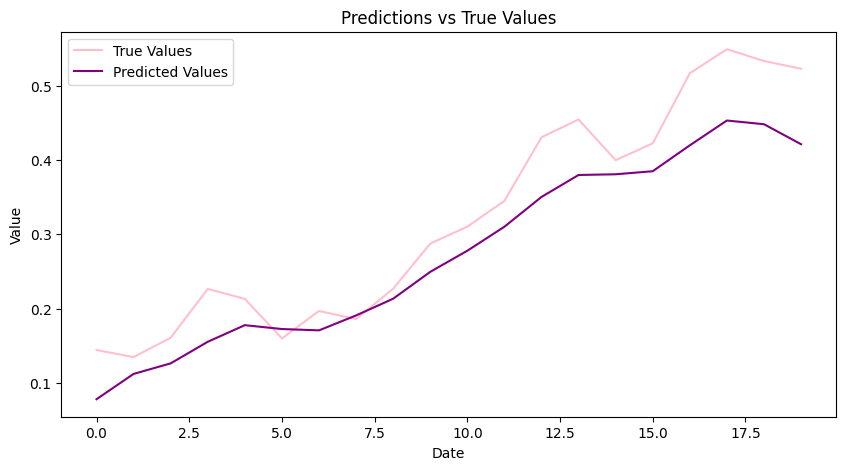

In [320]:
builder.graph_history(hist_stack1_3)
y_trueS,predictionsS = builder.predict(model_stack1_3)
builder.calculate_metrics(y_trueS, predictionsS)
builder.graph_prediction(y_trueS,predictionsS)

In [323]:
model_stack2_1, hist_stack2_1 = builder2.create_stacked_GRU(num_l1=64, num_l2=32, epochs=100,
                                                     name_model="Stacked_GRU2_1_64_32")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.4865 - mae: 0.5560 - val_loss: 0.1718 - val_mae: 0.3469
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.4618 - mae: 0.5545 - val_loss: 0.1683 - val_mae: 0.3442
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.4556 - mae: 0.5478 - val_loss: 0.1685 - val_mae: 0.3442
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.4522 - mae: 0.5451 - val_loss: 0.1687 - val_mae: 0.3443
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.4489 - mae: 0.5432 - val_loss: 0.1684 - val_mae: 0.3440
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.4454 - mae: 0.5412 - val_loss: 0.1681 - val_mae: 0.3437
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.4424 - mae: 0.5397 - val_loss: 0.1674 - val_mae: 0.3430
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.4387 - mae: 0.5375 - val_loss: 0.1674 - val_mae: 0.3429
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - lo

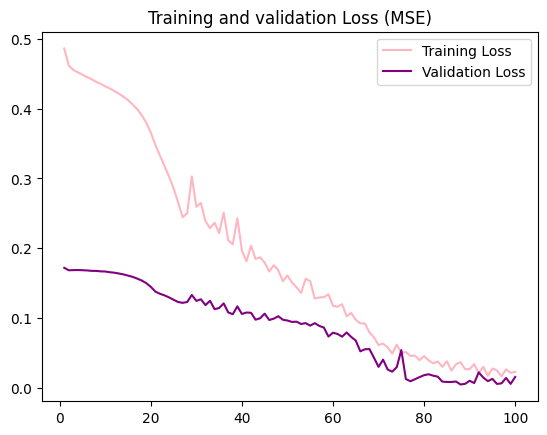

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
MAE: 0.1248
MSE: 0.0314
RMSE: 0.1773


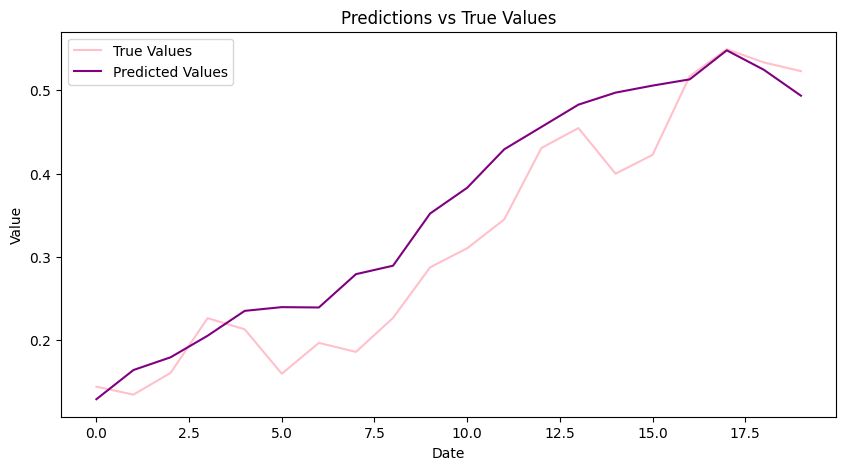

In [324]:
builder2.graph_history(hist_stack2_1)
y_trueS,predictionsS = builder2.predict(model_stack2_1)
builder2.calculate_metrics(y_trueS, predictionsS)
builder2.graph_prediction(y_trueS,predictionsS)

In [325]:
model_stack2_2, hist_stack2_2 = builder2.create_stacked_GRU(num_l1=128, num_l2=32, epochs=100,
                                                     name_model="Stacked_GRU2_2_128_32")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - loss: 0.4834 - mae: 0.5556 - val_loss: 0.1727 - val_mae: 0.3470
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.4596 - mae: 0.5525 - val_loss: 0.1679 - val_mae: 0.3434
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.4586 - mae: 0.5492 - val_loss: 0.1677 - val_mae: 0.3436
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.4563 - mae: 0.5475 - val_loss: 0.1685 - val_mae: 0.3445
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.4543 - mae: 0.5463 - val_loss: 0.1686 - val_mae: 0.3446
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.4511 - mae: 0.5444 - val_loss: 0.1685 - val_mae: 0.3446
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.4489 - mae: 0.5434 - val_loss: 0.1680 - val_mae: 0.3441
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.4457 - mae: 0.5414 - val_loss: 0.1678 - val_mae: 0.3438
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/

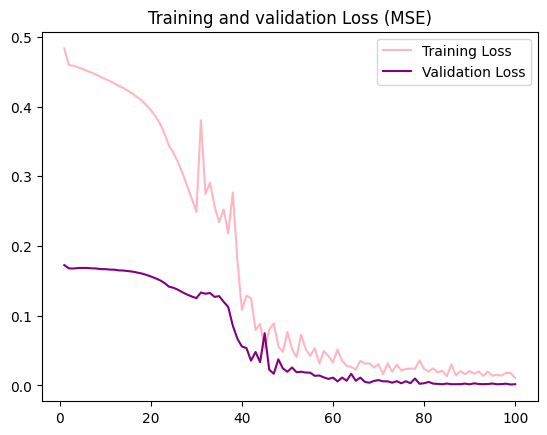

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
MAE: 0.1090
MSE: 0.0402
RMSE: 0.2005


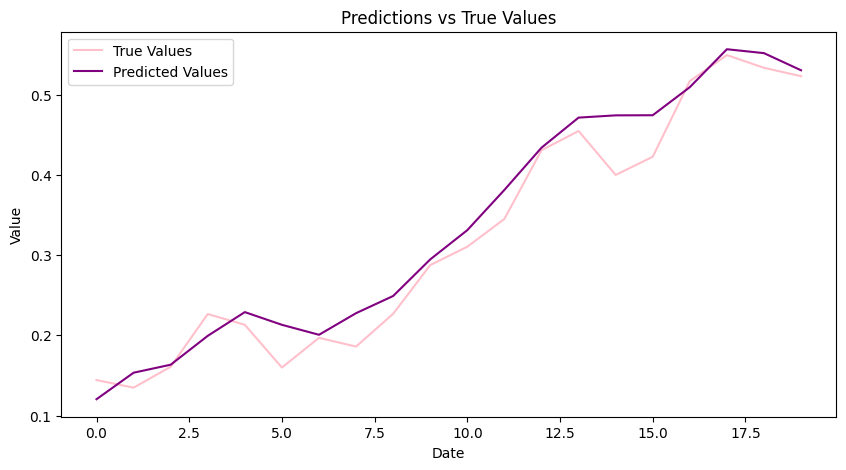

In [326]:
builder2.graph_history(hist_stack2_2)
y_trueS,predictionsS = builder2.predict(model_stack2_2)
builder2.calculate_metrics(y_trueS, predictionsS)
builder2.graph_prediction(y_trueS,predictionsS)

In [327]:
model_stack2_3, hist_stack2_3 = builder2.create_stacked_GRU(num_l1=128, num_l2=64, epochs=100,
                                                     name_model="Stacked_GRU2_3_128_64")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.5451 - mae: 0.6061 - val_loss: 0.1626 - val_mae: 0.3367
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.4507 - mae: 0.5476 - val_loss: 0.1549 - val_mae: 0.3297
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.4530 - mae: 0.5453 - val_loss: 0.1569 - val_mae: 0.3320
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.4558 - mae: 0.5463 - val_loss: 0.1587 - val_mae: 0.3342
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.4562 - mae: 0.5465 - val_loss: 0.1600 - val_mae: 0.3357
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.4544 - mae: 0.5459 - val_loss: 0.1607 - val_mae: 0.3364
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.4529 - mae: 0.5453 - val_loss: 0.1604 - val_mae: 0.3362
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.4491 - mae: 0.5435 - val_loss: 0.1603 - val_mae: 0.3361
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/

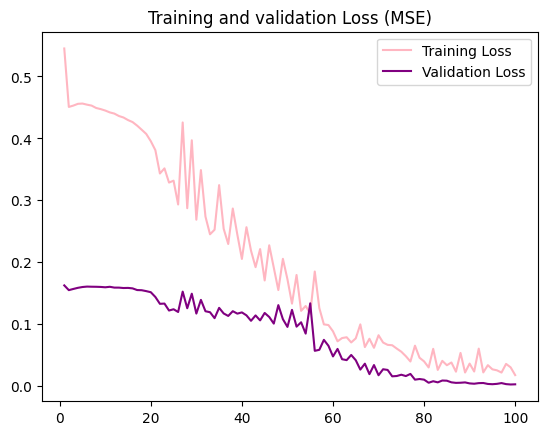

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
MAE: 0.1300
MSE: 0.0401
RMSE: 0.2002


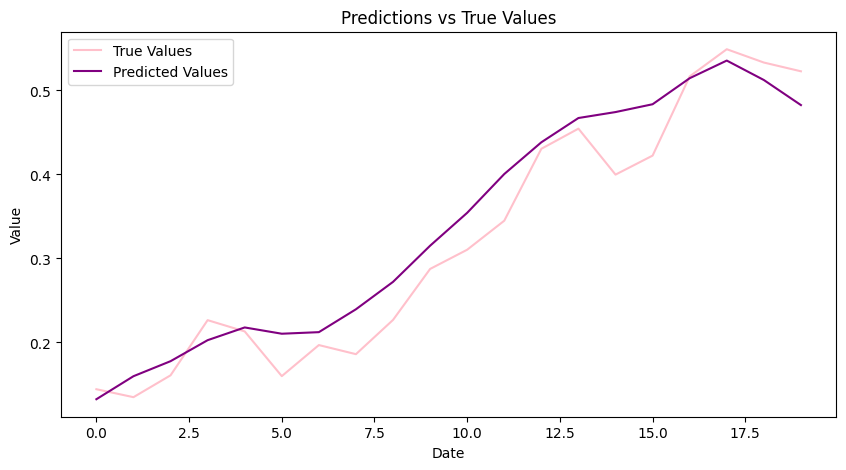

In [328]:
builder2.graph_history(hist_stack2_3)
y_trueS,predictionsS = builder2.predict(model_stack2_3)
builder2.calculate_metrics(y_trueS, predictionsS)
builder2.graph_prediction(y_trueS,predictionsS)

In [329]:
model_stack3_1, hist_stack3_1 = builder3.create_stacked_GRU(num_l1=64, num_l2=32, epochs=150,
                                                     name_model="Stacked_GRU3_1_64_32")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - loss: 0.5949 - mae: 0.6034 - val_loss: 0.2857 - val_mae: 0.4525
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 0.5955 - mae: 0.6082 - val_loss: 0.2737 - val_mae: 0.4438
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.5709 - mae: 0.5909 - val_loss: 0.2795 - val_mae: 0.4481
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.5624 - mae: 0.5862 - val_loss: 0.2838 - val_mae: 0.4508
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.5567 - mae: 0.5836 - val_loss: 0.2860 - val_mae: 0.4520
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 0.5521 - mae: 0.5814 - val_loss: 0.2872 - val_mae: 0.4528
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 0.5482 - mae: 0.5795 - val_loss: 0.2876 - val_mae: 0.4530
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.5444 - mae: 0.5777 - val_loss: 0.2880 - val_mae: 0.4533
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/

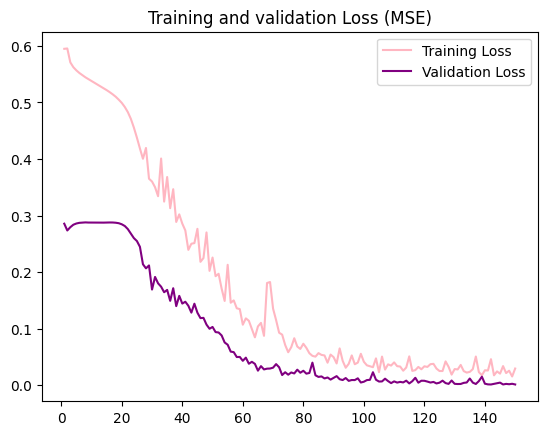

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
MAE: 0.0899
MSE: 0.0169
RMSE: 0.1300


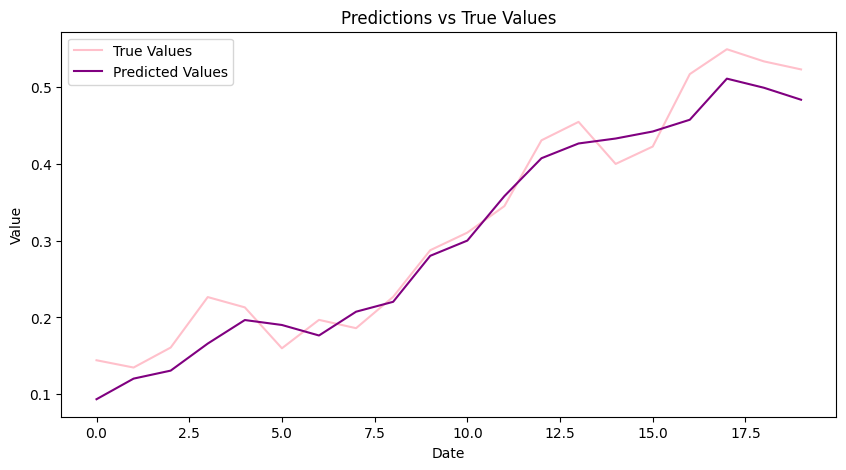

In [330]:
builder3.graph_history(hist_stack3_1)
y_trueS,predictionsS = builder3.predict(model_stack3_1)
builder3.calculate_metrics(y_trueS, predictionsS)
builder3.graph_prediction(y_trueS,predictionsS)

In [331]:
model_stack3_2, hist_stack3_2 = builder3.create_stacked_GRU(num_l1=128, num_l2=32, epochs=150,
                                                     name_model="Stacked_GRU3_2_128_32")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - loss: 0.6041 - mae: 0.5699 - val_loss: 0.2938 - val_mae: 0.4587
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - loss: 0.5787 - mae: 0.5954 - val_loss: 0.3018 - val_mae: 0.4644
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - loss: 0.5767 - mae: 0.5960 - val_loss: 0.3055 - val_mae: 0.4671
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - loss: 0.5744 - mae: 0.5952 - val_loss: 0.3036 - val_mae: 0.4655
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - loss: 0.5699 - mae: 0.5926 - val_loss: 0.3004 - val_mae: 0.4630
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - loss: 0.5651 - mae: 0.5898 - val_loss: 0.2975 - val_mae: 0.4607
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.5602 - mae: 0.5870 - val_loss: 0.2941 - val_mae: 0.4580
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.5561 - mae: 0.5846 - val_loss: 0.2916 - val_mae: 0.4562
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/

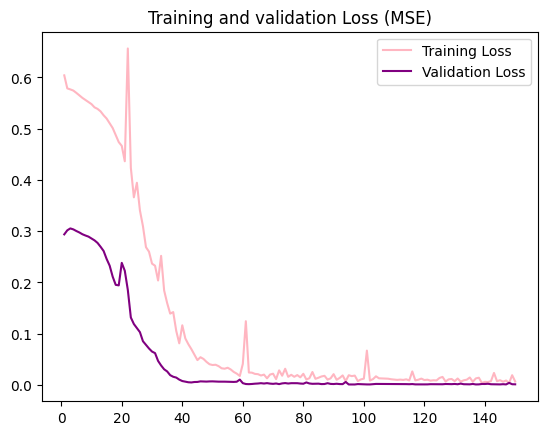

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
MAE: 0.0531
MSE: 0.0071
RMSE: 0.0843


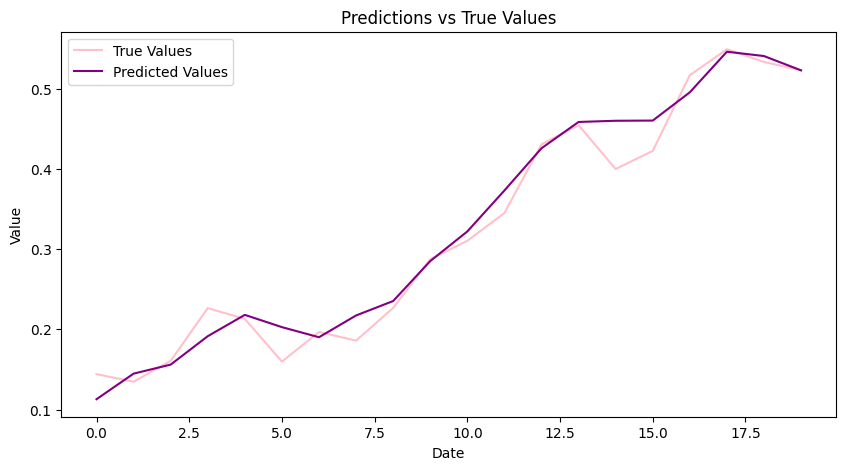

In [332]:
builder3.graph_history(hist_stack3_2)
y_trueS,predictionsS = builder3.predict(model_stack3_2)
builder3.calculate_metrics(y_trueS, predictionsS)
builder3.graph_prediction(y_trueS,predictionsS)

In [333]:
model_stack3_3, hist_stack3_3 = builder3.create_stacked_GRU(num_l1=128, num_l2=64, epochs=150,
                                                     name_model="Stacked_GRU3_3_128_64")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 420ms/step - loss: 0.6216 - mae: 0.5826 - val_loss: 0.2973 - val_mae: 0.4616
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 418ms/step - loss: 0.5905 - mae: 0.6004 - val_loss: 0.2974 - val_mae: 0.4609
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step - loss: 0.5800 - mae: 0.5973 - val_loss: 0.3023 - val_mae: 0.4647
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - loss: 0.5791 - mae: 0.5967 - val_loss: 0.2979 - val_mae: 0.4611
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - loss: 0.5740 - mae: 0.5935 - val_loss: 0.2943 - val_mae: 0.4582
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step - loss: 0.5698 - mae: 0.5906 - val_loss: 0.2905 - val_mae: 0.4551
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - loss: 0.5654 - mae: 0.5877 - val_loss: 0.2877 - val_mae: 0.4529
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step - loss: 0.5608 - mae: 0.5851 - val_loss: 0.2854 - val_mae: 0.4512
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/

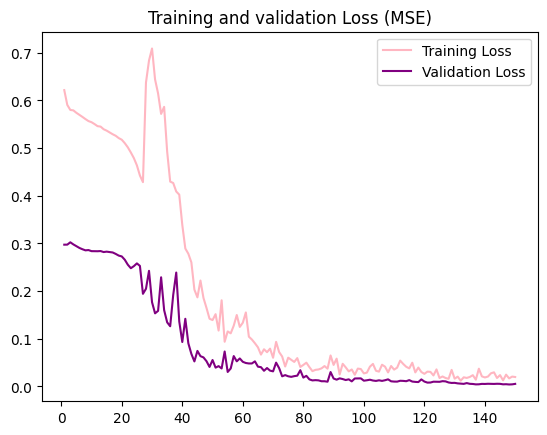

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step
MAE: 0.0558
MSE: 0.0053
RMSE: 0.0729


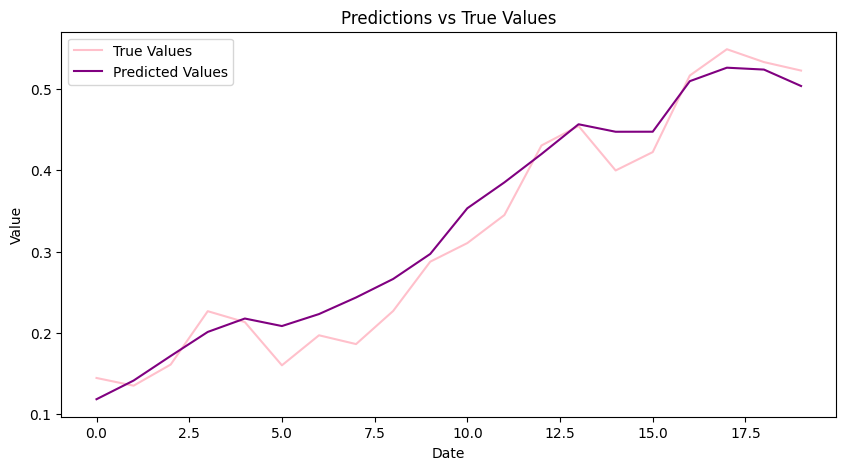

In [334]:
builder3.graph_history(hist_stack3_3)
y_trueS,predictionsS = builder3.predict(model_stack3_3)
builder3.calculate_metrics(y_trueS, predictionsS)
builder3.graph_prediction(y_trueS,predictionsS)